# GPCR ODE Model

This is the ODE system for the glutamate GPCR receptor inside of an astrocyte. The model is based on the following diagram:

<img src="GCPR_model.jpg" width=400 />

|Variable|Meaning|Python variable name|
|---|---|---|
|$G$|Inactivate glutamate receptor|G|
|$G^*$|Activated glutamate receptor|Gstar|
|$G_{d1}$|Deactivated (homologous) receptor|Gd1|
|$G_{d2}$|Deactivated (heterlogous) receptor|Gd2|

|Parameter|Meaning|Python variable name
|---|---|---|
|$k_+$|Activation constant $G \rightarrow G^*$|kp|
|$k_-$|Inactivation constant $G^* \rightarrow G$|km|
|$\gamma$|Concentration of glutamate|glut|
|$k_{d1}$|Deactivation (homologous) $G^* \rightarrow G_{d1}$|kd1|
|$k_{r1}$|Reactivation $G_{d1} \rightarrow G$|kr1|
|$k_{d2}$|Deactivation (heterlogous) $G \rightarrow G_{d2}$|kd2|
|$k_{r2}$|Reactivation $G_{d2} \rightarrow G$|kr2|

The ODE equations are as following:
$$ 
\begin{align}
\frac{dG^*}{dt} &= k_+ \gamma G - k_- G^* - k_{d1} G^* \\
\frac{dG_{d1}}{dt} &= k_{d1}G^* - k_{r1} G_{d1} \\
\frac{dG_{d2}}{dt} &= k_{d2}G^* G - k_{r2} G_{d2}
\end{align}
$$
and $G$ is given implicitly as $G = 1 - G^* - G_{d1} - G_{d2}$

In [1]:
'''
Import necessary packages
'''
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import os

#set figure font sizes for readability
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

In [2]:
'''
Initiate parameter values
'''
#G <-> G*
kp = 0.03 #activation rate
km = 0.04 #inactivation rate

#G* -> Gd1 -> G
kd1 = 0.01 #homologous (Gd1) deactivation rate
kr1 = 0.005 #0.003 #homologous reactivation rate
#G -> Gd2 -> G
kd2 = 0.003 #0.0025 #heterologous (Gd2) deactivation rate
kr2 = 0.0007 #0.0004 #heterologous reactivation rate

#Square wave glutamate pulse parameters
glut_start = 10
glut_duration = 750
glut_max = 10
glut_min = 0

#oscillation parameters
oscillation_on_duration = 50
oscillation_off_duration = 150
num_oscillations = 2

#Initial conditions
t_0 = 0
x_0 = [0, 0, 0]

#Final time
t_f = 1000



param_dict = {
    'kp': kp,
    'km': km,
    'kd1': kd1,
    'kr1': kr1,
    'kd2': kd2,
    'kr2': kr2
}


#double exponential input parameters
compute_r_decay = lambda A, d_decay: -1 / d_decay * np.log(0.005 / A)
A = 0.2
d_rise = 21
r_rise = 0.002
d_decay = 97
r_decay = compute_r_decay(A, d_decay)
'''
Figure save location
'''
save = 'figures/glutamate_gpcr/'

In [25]:
def ode_equations(t, x, input_type='pulse'):
    '''
    ODE equations following the GPCR equations given earlier
    x[0] = Gstar
    x[1] = Gd1
    x[2] = Gd2
    This returns x_dot, which is an array of the right hand sides of 
    each of the ODE equations in the same order as above
    
    input_type: given by ODE args, can be 'pulse' or 'step'
    '''
    global param_dict
    kp = param_dict['kp']
    km = param_dict['km']
    kd1 = param_dict['kd1']
    kd2 = param_dict['kd2']
    kr1 = param_dict['kr1']
    kr2 = param_dict['kr2']
    
    Gstar = x[0]
    Gd1 = x[1]
    Gd2 = x[2]
    G = 1 - Gstar - Gd1 - Gd2
    
    #query our glutamate function for what level glutamate is input
    if(input_type == 'pulse'):
        glut = glutamate_pulse_input(t)
    elif(input_type == 'step'):
        glut = glutamate_step_input(t)
    elif(input_type == 'oscillation'):
        glut = glutamate_oscillation_input(t)
    elif(input_type == 'exponential_oscillation'):
        glut = glutamate_exponential_oscillation(t)
    
    x_dot = np.zeros(3)
    
    x_dot[0] = kp*glut*G - km*Gstar - kd1*Gstar
    x_dot[1] = kd1*Gstar - kr1*Gd1
    #x_dot[2] = kd2*Gstar*G - kr2*Gd2
    x_dot[2] = kd2*Gstar*G*(Gd2+0.01) - kr2*Gd2
    
    return x_dot



def glutamate_pulse_input(t):
    '''
    This function tells us what value glutamate takes at a given time t
    Currently set to square wave
    '''
    if(t > glut_start and t < (glut_start + glut_duration)):
        glut = glut_max
    else:
        glut = glut_min
    return glut


def glutamate_step_input(t):
    '''
    This function will create an IP3 input that increases stepwise
    0-50ms: 0
    50-200ms: 0.125
    200-350ms: 0.250
    350-500ms: 0.375
    500-650ms: 0.5
    650-800ms: 0.375
    800-950ms: 0.250
    950-1100ms: 0.125
    1100ms-: 0
    '''
    #times at which the concentration changes
    time_breaks = [0, 50, 200, 350, 500, 650, 800, 950, 1100]
    #values the concentration changes to at each interval
    ip3_values = [0, 0.5, 1, 1.5, 2, 1.5, 1, 0.5, 0]

    for i in range(len(time_breaks)):
        #check if t is after last time_break
        if(i == len(time_breaks) - 1):
            if(t >= time_breaks[i]):
                return ip3_values[i]

        #check which interval t is in
        else:
            if(t >= time_breaks[i] and t < time_breaks[i+1]):
                return ip3_values[i]
            
            
            
def glutamate_oscillation_input(t):
    '''
    This function creates an oscillatory glutamate input
    '''
    global num_oscillations
    global oscillation_on_duration
    global oscillation_off_duration
    
    principle_t = (t) % (oscillation_on_duration + oscillation_off_duration)
    
#     print((oscillation_off_duration + oscillation_on_duration) * num_oscillations)
    if(principle_t < oscillation_on_duration and
        t < (oscillation_off_duration + oscillation_on_duration) * num_oscillations):
        return glut_max
    else:
        return glut_min
    
    
    

def glutamate_exponential_oscillation(t):
    '''
    This function creates an oscillatory glutamate input where the input grows
    and falls exponentially
    '''
    #compute our IP3 curve helper functions
    oscillation_on_duration = d_rise + d_decay
    principle_t = t % (oscillation_on_duration + oscillation_off_duration)
    
    
    if(principle_t < oscillation_on_duration and
      t < (oscillation_on_duration + oscillation_off_duration) * num_oscillations):
        s_inf = A / (1 - np.exp(-r_rise * d_rise))
        if(principle_t < d_rise):
            return s_inf * (1 - np.exp(-r_rise * (principle_t)))
        elif(principle_t >= d_rise):
            return A * np.exp(-r_decay * (principle_t - d_rise))
    else:
        return 0
    

            
def get_input_plot(input_type, t_f=1000):
    '''
    This function simply returns t and y values to plot
    based on the type of input curve that we used
    E.g., we could call this to get glut_t, glut for the glutamate
    input plot
    '''
    t = np.arange(t_0, t_f, t_f/100000)
    y = []
    for x in t:
        if(input_type == 'pulse'):
            y.append(glutamate_pulse_input(x))
        elif(input_type == 'step'):
            y.append(glutamate_step_input(x))
        elif(input_type == 'oscillation'):
            y.append(glutamate_oscillation_input(x))
        elif(input_type == 'curve'):
            y.append(ip3_curve_input(x))
        elif(input_type == 'exponential_oscillation'):
            y.append(glutamate_exponential_oscillation(x))
    y = np.array(y)
    return t, y

In [8]:
def run_experiment(change_param_dict={}, t_0=0, t_f=1000, max_step=1, input_type='pulse',
                  make_plot=True, save_plot=False):
    '''
    Run the ode simulation with the given change_param_dict values
    Note that we will revert the param dict back to default settings after running the simulation
    
    t_0: start time
    t_f: end time
    input_type: 'pulse'/'step'/'oscillation'
    make_plot: whether to create the plot
    save_plot: whether to save the plot. A string should be passed for the name
        e.g. if 'test' is passed, we will save 'figures/glutamate_gpcr/test.pdf'
    '''
    global param_dict
    global kp
    global km
    global kd1
    global kd2
    global kr1
    global kr2
    
    global Gstar
    global Gd1
    global Gd2
    global G
    global t
    for key in change_param_dict.keys():
        param_dict[key] = change_param_dict[key]
    
    #run the numerical ODE solver
    sol = scipy.integrate.solve_ivp(ode_equations, [t_0, t_f], x_0, args=[input_type], max_step=max_step)

    #get the output arrays from the solver
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    sol['glutamate_input_type'] = input_type
    
    #if make_plot == True, make the plot
    if(make_plot):
        plt.figure(figsize=(10,20))

        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10,10))

        #set glutamate plot curve
        glut_t, glut = get_input_plot(sol['glutamate_input_type'])

        #plot figures
        ax[0].plot(glut_t, glut)
        ax[1].plot(t, Gstar)
        ax[2].plot(t, G)
        ax[3].plot(t, Gd1)
        ax[4].plot(t, Gd2)

        #set xlabel
        ax[4].set_xlabel('t')

        #set ylabels
        ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
        ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
        ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
        ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
        ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

        #align ylabels
        ax[0].get_yaxis().set_label_coords(-0.23,0.4)
        ax[1].get_yaxis().set_label_coords(-0.23,0.4)
        ax[2].get_yaxis().set_label_coords(-0.23,0.4)
        ax[3].get_yaxis().set_label_coords(-0.23,0.35)
        ax[4].get_yaxis().set_label_coords(-0.23,0.35)

        fig.tight_layout()
        
    #save the figure as the given name
    if(save_plot != False and make_plot):
        if('figures' not in os.listdir()):
            os.mkdir('figures')
        if('glutamate_gpcr' not in os.listdir('figures')):
            os.mkdir('figures/glutamate_gpcr')
        
        fig.savefig('figures/glutamate_gpcr/' + save_plot + '.png', bbox_inches='tight')
        
        
    #reset the global param_dict back to default values after experiment
    param_dict = {
        'km': km,
        'kp': kp,
        'kd1': kd1,
        'kd2': kd2,
        'kr1': kr1,
        'kr2': kr2
    }
    
    #return the solution found
    return sol

---
# Base Configuration (Pulse, Step, Oscillation)

The following three plots are run with simply the base configuration and the three types of glutamate input


## Pulse

<Figure size 720x1440 with 0 Axes>

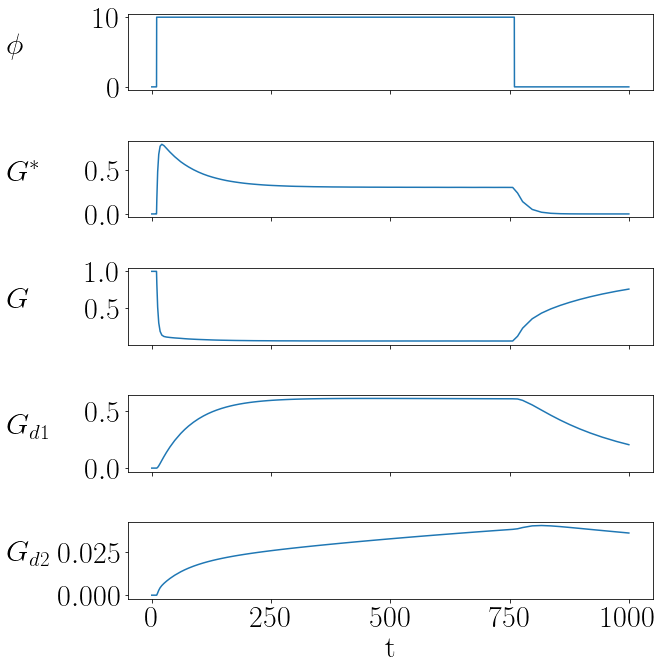

In [38]:
sol = run_experiment(save_plot='2.1_base_pulse')

## Step

<Figure size 720x1440 with 0 Axes>

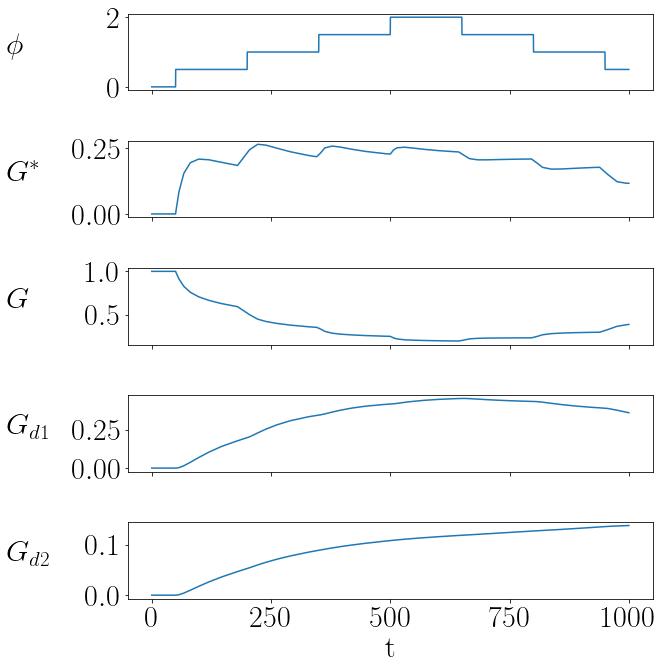

In [39]:
sol = run_experiment(input_type='step', save_plot='2.2_base_step')

## Oscillation

<Figure size 720x1440 with 0 Axes>

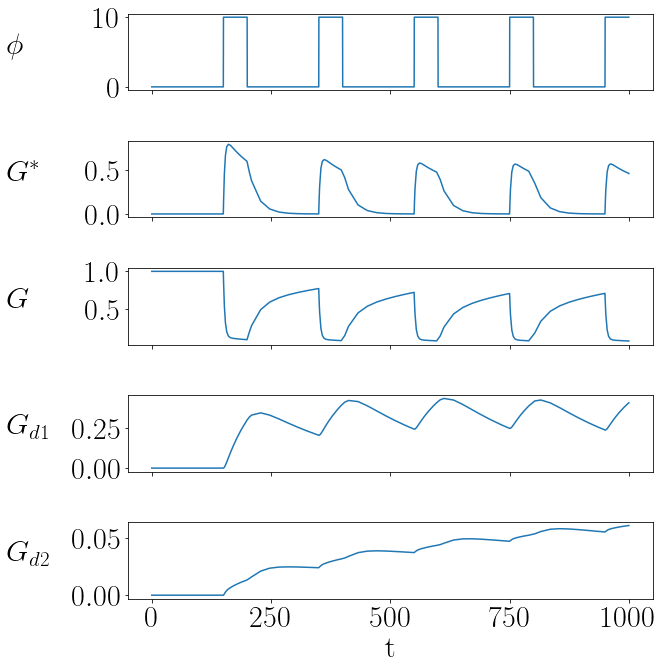

In [40]:
sol = run_experiment(input_type='oscillation', save_plot='2.3_base_oscillation')

---

# Adjust kd2 (heterlogous inactivation)

Alla mentioned that G_d2 never seems to become very large. The obvious thing to tweak is kd2, as this is the inactivation rate

## kd2: 0.003 -> 0.1

All we're doing here is increasing the value of kd2 to show that we can indeed get G_d2 up

<Figure size 720x1440 with 0 Axes>

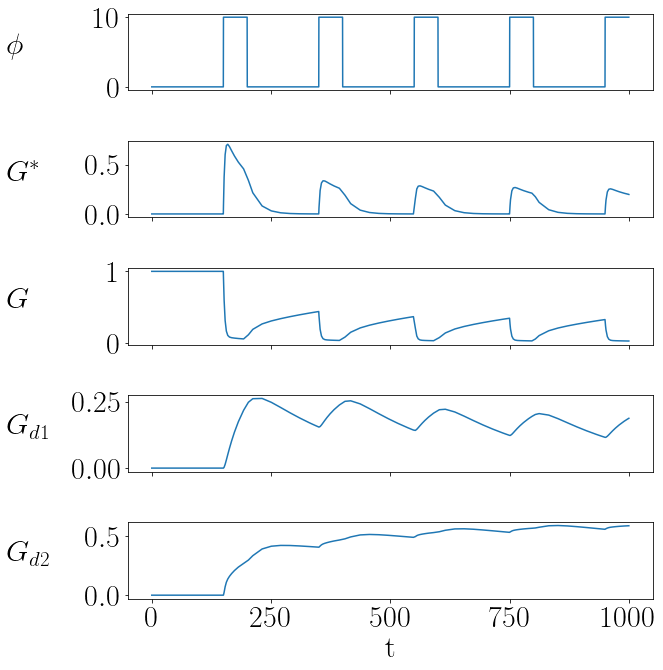

In [41]:
sol = run_experiment({'kd2': 0.1}, save_plot='3.1_increase_kd2_0.1', input_type='oscillation')

## kd2 range

Here, we show just the G_d2 levels alone with different parameter values for kd2

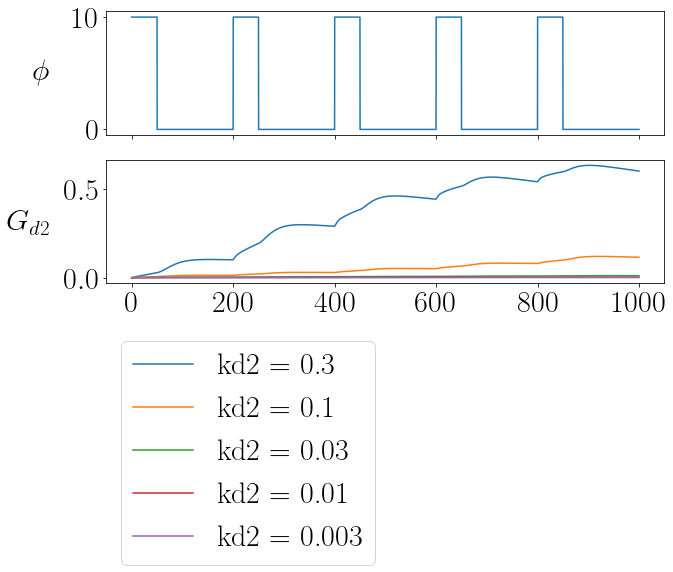

In [8]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

for kd2 in [0.3, 0.1, 0.03, 0.01, 0.003]:
    sol = run_experiment({'kd2': kd2}, make_plot=False, input_type='oscillation')
    Gd2 = sol.y[2]
    t = sol.t
    
    ax[1].plot(t, Gd2, label='kd2 = '+ str(kd2))

glut_t, glut = get_input_plot('oscillation')
ax[0].plot(glut_t, glut)
ax[1].legend(loc='lower left', bbox_to_anchor=(0, -2.4))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[0].get_yaxis().set_label_coords(-0.1, 0.4)
ax[1].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')
ax[1].get_yaxis().set_label_coords(-0.1, 0.35)

#fig.savefig(save + '3.2_kd2_range.png', bbox_inches='tight')

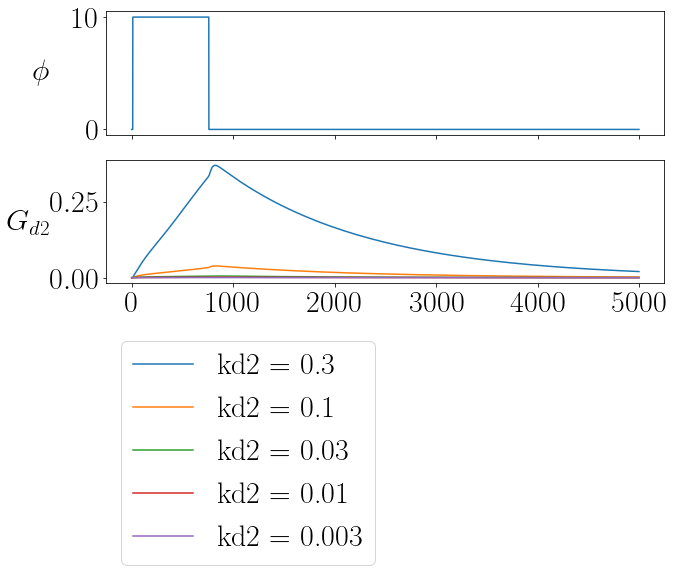

In [76]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
t_f=5000

for kd2 in [0.3, 0.1, 0.03, 0.01, 0.003]:
    sol = run_experiment({'kd2': kd2}, make_plot=False, input_type='pulse', t_f=5000)
    Gd2 = sol.y[2]
    t = sol.t
    
    ax[1].plot(t, Gd2, label='kd2 = '+ str(kd2))

glut_t, glut = get_input_plot('pulse')
ax[0].plot(glut_t, glut)
ax[1].legend(loc='lower left', bbox_to_anchor=(0, -2.4))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[0].get_yaxis().set_label_coords(-0.1, 0.4)
ax[1].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')
ax[1].get_yaxis().set_label_coords(-0.1, 0.35)

t_f=1000
#fig.savefig(save + '3.2_kd2_range.png', bbox_inches='tight')

## kd2 range (all plots)

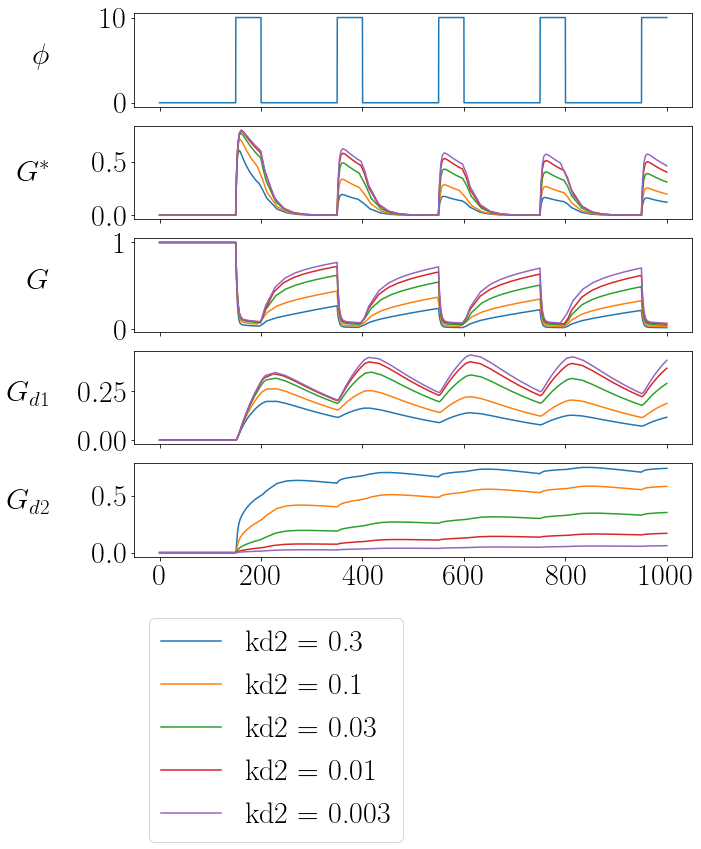

In [58]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

for kd2 in [0.3, 0.1, 0.03, 0.01, 0.003]:
    sol = run_experiment({'kd2': kd2}, make_plot=False, input_type='oscillation')
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='kd2 = '+ str(kd2))

glut_t, glut = get_input_plot('oscillation')
ax[0].plot(glut_t, glut)
ax[4].legend(loc='lower left', bbox_to_anchor=(0, -3.2))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='right')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='right')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='right')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')

ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)
ax[2].get_yaxis().set_label_coords(-0.15, 0.4)
ax[3].get_yaxis().set_label_coords(-0.15, 0.35)
ax[4].get_yaxis().set_label_coords(-0.15, 0.4)

fig.savefig(save + '3.3_kd2_range_all.png', bbox_inches='tight')

---

# Adjust kr2

Curious to see how quickly G_d2 recovers back to G. Note that the original value is 
$$k_{r2} = 0.0007$$

## kr2 range, quick pulse

Here, testing to see how quickly the G_d2 recovers for a range of kr2 values.

In hindsight seems obvious but increases in kr2 lead to lower amounts of G_d2 overall. Also notably, for higher values of kr2 (kr2 >= 0.005) we see that G_d2 gets a local maximum, which doesn't occur here for the kr2 = 0.001, 0.0007 cases. 

There is an initial fast growth phase due to the initial growth of G*, which dies off as G* gets inactivated to G_d1

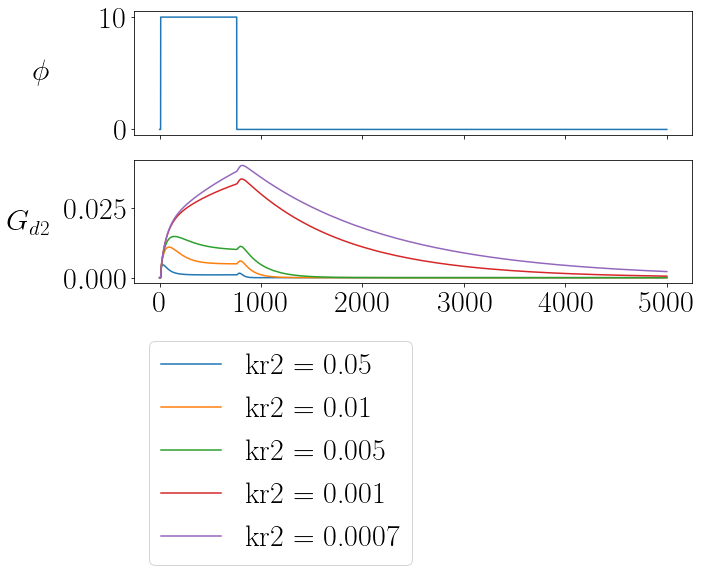

In [60]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

t_f=5000

for kr2 in [0.05, 0.01, 0.005, 0.001, 0.0007]:
    sol = run_experiment({'kr2': kr2}, make_plot=False, input_type='pulse', t_f=5000)
    Gd2 = sol.y[2]
    t = sol.t
    
    ax[1].plot(t, Gd2, label='kr2 = '+ str(kr2))

glut_t, glut = get_input_plot('pulse')
ax[0].plot(glut_t, glut)
ax[1].legend(loc='lower left', bbox_to_anchor=(0, -2.4))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)

fig.savefig(save + '4.1_kr2_range.png', bbox_inches='tight')

t_f=1000

## kr2 range (all plots)

Here we explore the effects of the same range of kr2 values on all the different components. It appears that very little is changed, though this may simply be due to the low overall magnitude of G_d2 relative to the other components at all times (this in contrast with the all plots figure in 3.3)

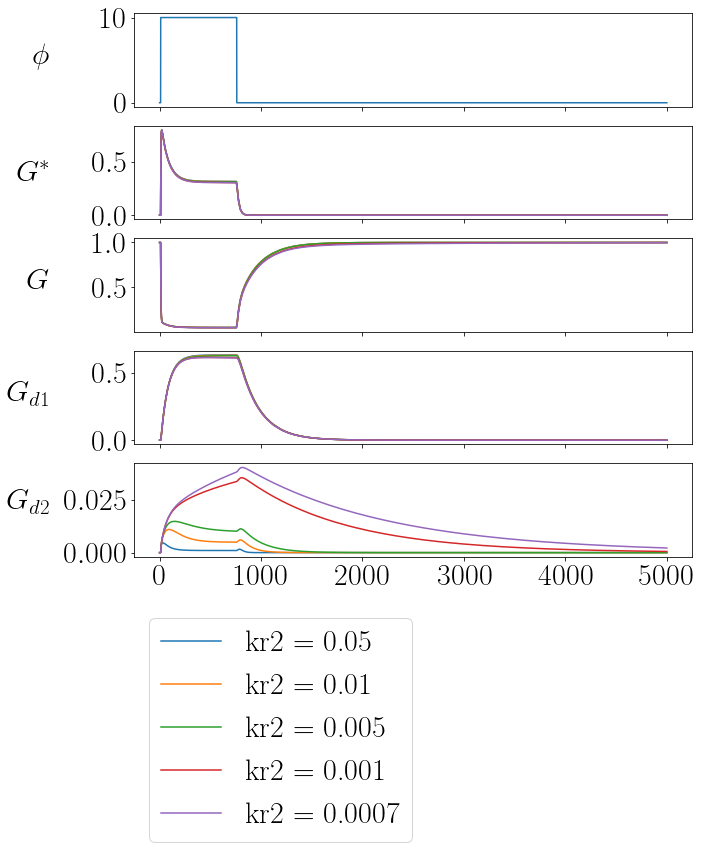

In [59]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

t_f=5000

for kr2 in [0.05, 0.01, 0.005, 0.001, 0.0007]:
    sol = run_experiment({'kr2': kr2}, make_plot=False, input_type='pulse', t_f=5000)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='kr2 = '+ str(kr2))

glut_t, glut = get_input_plot('pulse')
ax[0].plot(glut_t, glut)
ax[4].legend(loc='lower left', bbox_to_anchor=(0, -3.2))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='right')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='right')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='right')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')

ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)
ax[2].get_yaxis().set_label_coords(-0.15, 0.4)
ax[3].get_yaxis().set_label_coords(-0.15, 0.35)
ax[4].get_yaxis().set_label_coords(-0.15, 0.4)

fig.savefig(save + '4.2_kr2_range_all.png', bbox_inches='tight')

t_f=1000

### kr2 range (decreasing kr2)

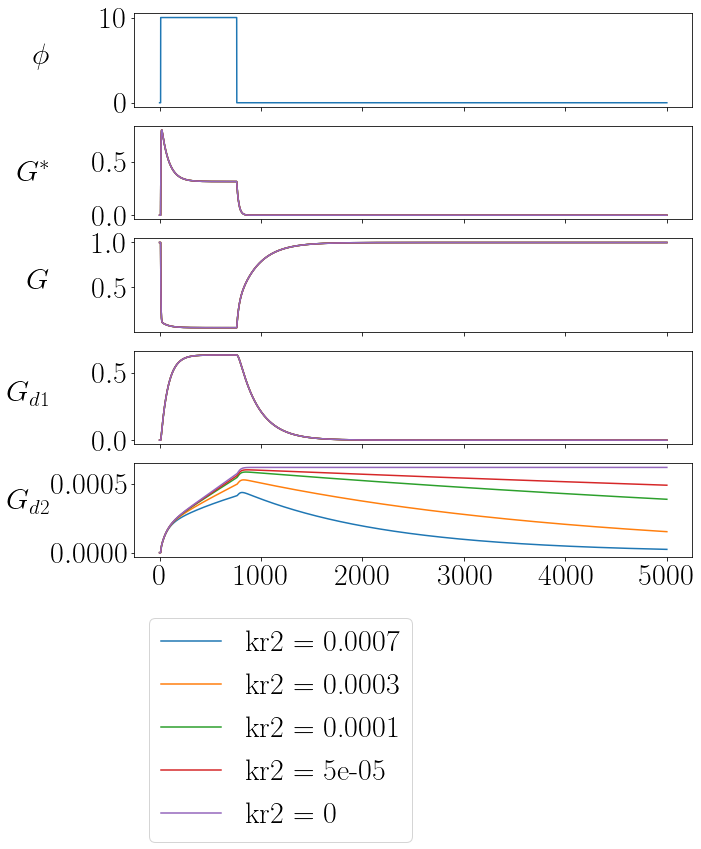

In [11]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

t_f=5000

for kr2 in [0.0007, 0.0003, 0.0001, 0.00005, 0]:
    sol = run_experiment({'kr2': kr2}, make_plot=False, input_type='pulse', t_f=5000)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='kr2 = '+ str(kr2))

glut_t, glut = get_input_plot('pulse', t_f)
ax[0].plot(glut_t, glut)
ax[4].legend(loc='lower left', bbox_to_anchor=(0, -3.2))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='right')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='right')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='right')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')

ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)
ax[2].get_yaxis().set_label_coords(-0.15, 0.4)
ax[3].get_yaxis().set_label_coords(-0.15, 0.35)
ax[4].get_yaxis().set_label_coords(-0.15, 0.4)

fig.savefig(save + '4.2.1_kr2_range_lower_all.png', bbox_inches='tight')

t_f=1000

## kr2 range (all plots), kd2: 0.003 -> 0.1

The inspiration for this plot was to see if increasing kd2 (and hence the amount of G_d2) would replicate the 3.3 plot where the other components are affected by the change to kr2. 

Here we can see quite clearly how increases in kr2 allow G to return quickly to initial values

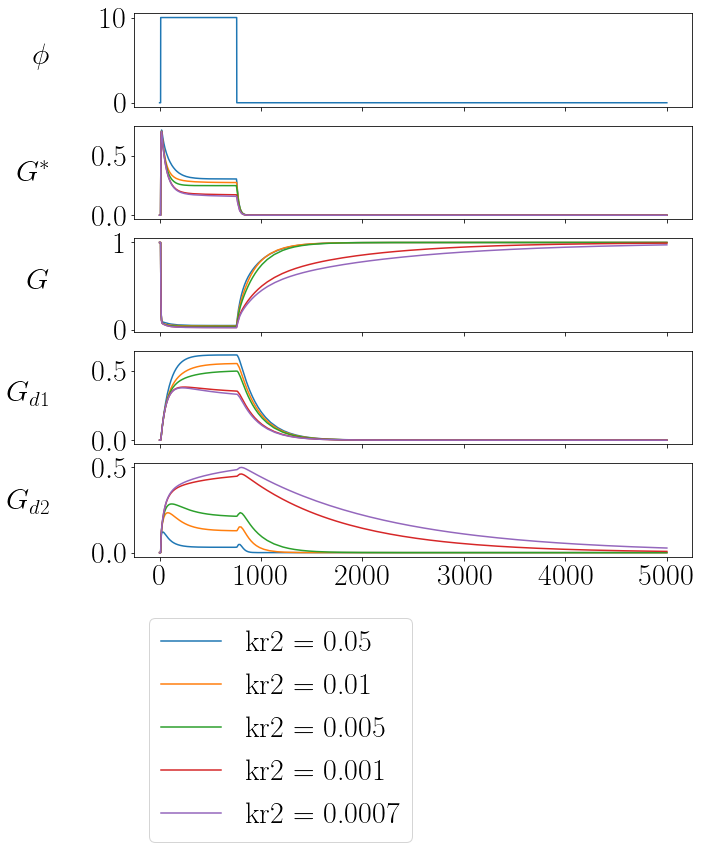

In [68]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

t_f=5000

for kr2 in [0.05, 0.01, 0.005, 0.001, 0.0007]:
    sol = run_experiment({'kr2': kr2, 'kd2': 0.1}, 
                         make_plot=False, input_type='pulse', t_f=5000)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='kr2 = '+ str(kr2))

glut_t, glut = get_input_plot('pulse')
ax[0].plot(glut_t, glut)
ax[4].legend(loc='lower left', bbox_to_anchor=(0, -3.2))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='right')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='right')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='right')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')

ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)
ax[2].get_yaxis().set_label_coords(-0.15, 0.4)
ax[3].get_yaxis().set_label_coords(-0.15, 0.35)
ax[4].get_yaxis().set_label_coords(-0.15, 0.4)

fig.savefig(save + '4.3_kr2_range_all_higher_kd2.png', bbox_inches='tight')

t_f=1000

### kr2 range lower, kd2 0.003 -> 0.007

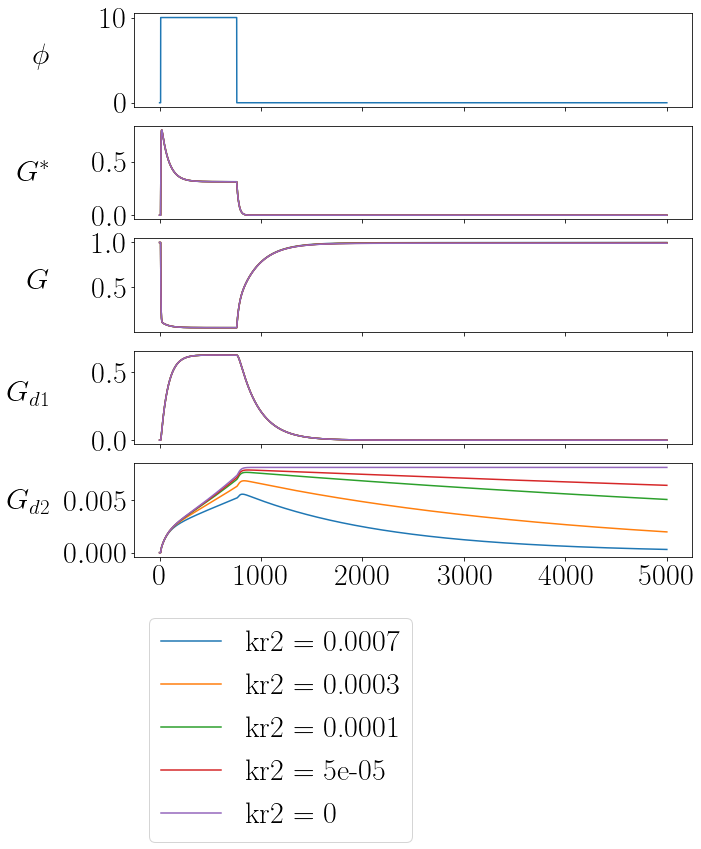

In [13]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

t_f=5000

for kr2 in [0.0007, 0.0003, 0.0001, 0.00005, 0]:
    sol = run_experiment({'kr2': kr2, 'kd2': 0.03}, make_plot=False, input_type='pulse', t_f=5000)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='kr2 = '+ str(kr2))

glut_t, glut = get_input_plot('pulse', t_f)
ax[0].plot(glut_t, glut)
ax[4].legend(loc='lower left', bbox_to_anchor=(0, -3.2))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='right')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='right')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='right')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')

ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)
ax[2].get_yaxis().set_label_coords(-0.15, 0.4)
ax[3].get_yaxis().set_label_coords(-0.15, 0.35)
ax[4].get_yaxis().set_label_coords(-0.15, 0.4)

fig.savefig(save + '4.3.1_kr2_range_lower_higher_kd2.png', bbox_inches='tight')

t_f=1000

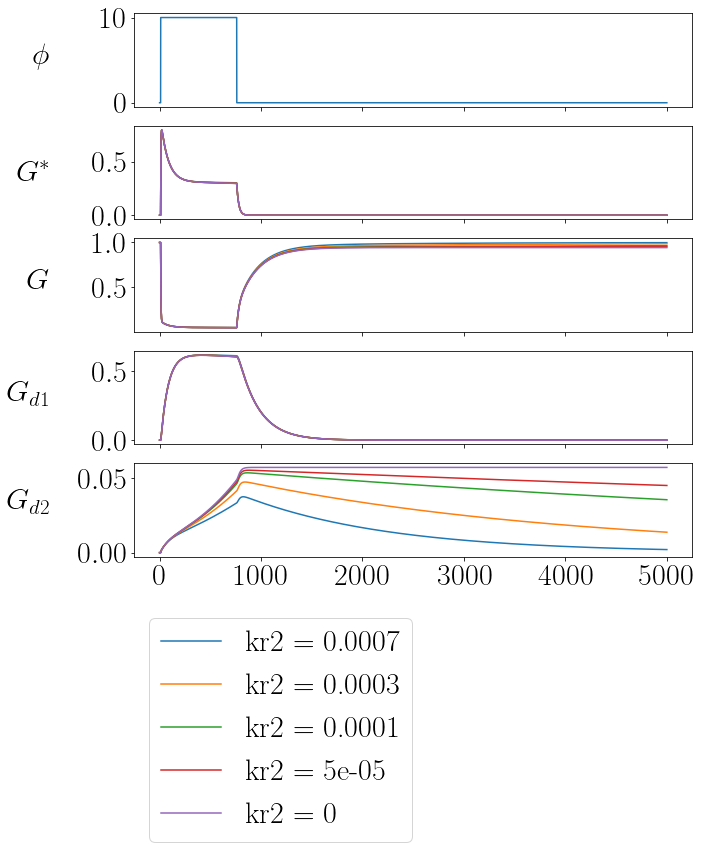

In [14]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

t_f=5000

for kr2 in [0.0007, 0.0003, 0.0001, 0.00005, 0]:
    sol = run_experiment({'kr2': kr2, 'kd2': 0.1}, make_plot=False, input_type='pulse', t_f=5000)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t
    
    
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='kr2 = '+ str(kr2))

glut_t, glut = get_input_plot('pulse', t_f)
ax[0].plot(glut_t, glut)
ax[4].legend(loc='lower left', bbox_to_anchor=(0, -3.2))

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='right')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='right')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='right')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')

ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
ax[1].get_yaxis().set_label_coords(-0.15, 0.35)
ax[2].get_yaxis().set_label_coords(-0.15, 0.4)
ax[3].get_yaxis().set_label_coords(-0.15, 0.35)
ax[4].get_yaxis().set_label_coords(-0.15, 0.4)

fig.savefig(save + '4.3.1_kr2_range_lower_higher_kd2.png', bbox_inches='tight')

t_f=1000

---

# Requested Experiments

These experiments were listed in an email that Alla sent about experiments that she and Marsa wanted to run

## Long application of glutamate

<Figure size 720x1440 with 0 Axes>

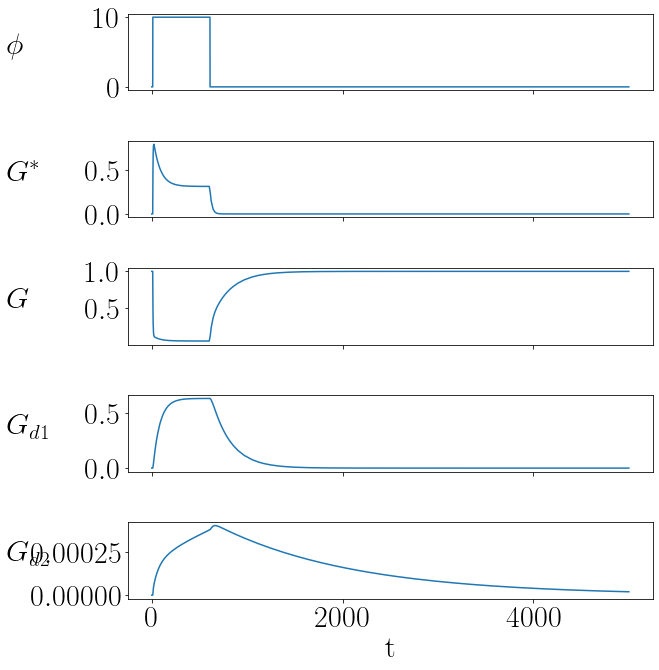

In [6]:
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

t_f=5000
glut_duration=600

sol = run_experiment(make_plot=True, input_type='pulse', t_f=5000)
Gd2 = sol.y[2]
t = sol.t

# ax[1].plot(t, Gd2, label='kr2 = '+ str(kr2))

# glut_t, glut = get_input_plot('pulse')
# ax[0].plot(glut_t, glut)
# ax[1].legend(loc='lower left', bbox_to_anchor=(0, -2.4))

# ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='right')
# ax[0].get_yaxis().set_label_coords(-0.15, 0.4)
# ax[1].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='right')
# ax[1].get_yaxis().set_label_coords(-0.15, 0.35)

plt.savefig(save + '5.1_glutamate_long.png', bbox_inches='tight')

glut_duration=70
t_f=1000

## Double bath

Square pulse of glutamate (150s, phi=5), followed by an idential square pulse after x seconds
Plot as a function of x:
* Max G* during second pulse
* Value of G* at the end of second pulse
* Integral of G* during second pulse

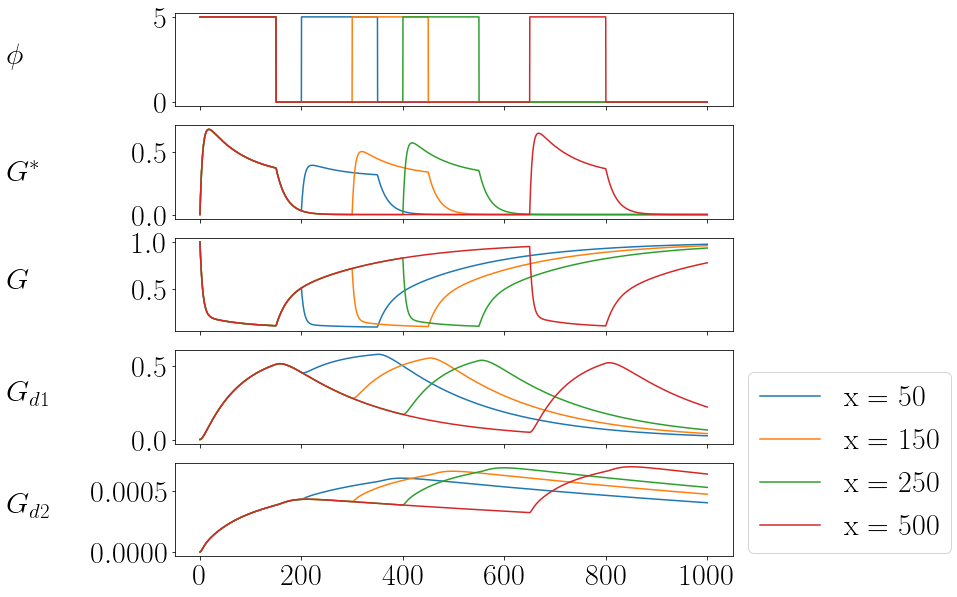

<Figure size 720x720 with 0 Axes>

In [28]:
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))

num_oscillations = 2
oscillation_on_duration = 150
glut_max = 5

xs = np.array([50, 150, 250, 500])
max_Gstars = []
end_Gstars = []
second_pulse_Gstars = []

for x in [50, 150, 250, 500]:
    oscillation_off_duration = x
    
    sol = run_experiment(make_plot=False, input_type='oscillation')
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t

    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='x = '+ str(x))

    glut_t, glut = get_input_plot('oscillation')
    ax[0].plot(glut_t, glut)
    
    #-------
    #Compute details
    #-------
    #Starting from second pulse
    start_pulse_index = np.argmax(t > (x + 150))
    end_pulse_index = np.argmax(t > (x + 300))
    
    #1. Max G*
    max_Gstar = Gstar[start_pulse_index:].max()
    
    #2. G* at end of second pulse
    end_Gstar = Gstar[end_pulse_index]
    
    #3 Integral of G* over second pulse
    mean_Gstar = Gstar[start_pulse_index:end_pulse_index].mean()
    second_pulse_Gstar = mean_Gstar * 150
    
    max_Gstars.append(max_Gstar)
    end_Gstars.append(end_Gstar)
    second_pulse_Gstars.append(second_pulse_Gstar)

ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

ax[4].legend(loc='center left', bbox_to_anchor=(1, 1))

ax[0].get_yaxis().set_label_coords(-0.3, 0.4)
ax[1].get_yaxis().set_label_coords(-0.3, 0.35)
ax[2].get_yaxis().set_label_coords(-0.3, 0.4)
ax[3].get_yaxis().set_label_coords(-0.3, 0.35)
ax[4].get_yaxis().set_label_coords(-0.3, 0.35)


fig.savefig(save + '5.2_glutamate_oscillations.png', bbox_inches='tight')

oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


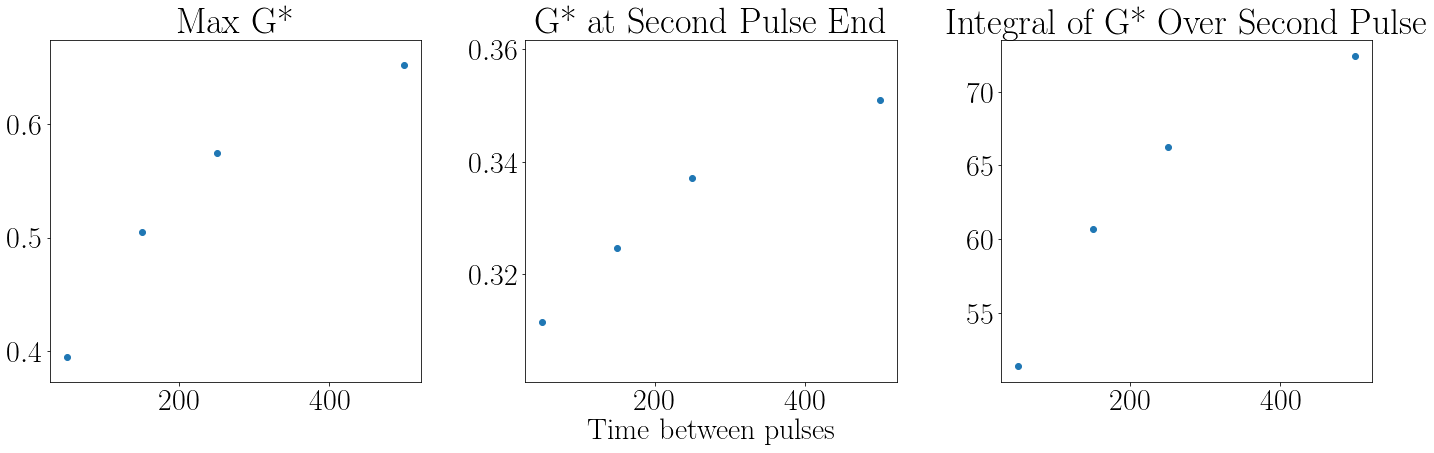

In [29]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 3, figsize=(21,7))

ax[0].scatter(xs, max_Gstars)
ax[1].scatter(xs, end_Gstars)
ax[2].scatter(xs, second_pulse_Gstars)

ax[0].set_title('Max G*')
ax[1].set_title('G* at Second Pulse End')
ax[2].set_title('Integral of G* Over Second Pulse')

ax[1].set_xlabel('Time between pulses')

fig.tight_layout()

fig.savefig(save + '5.2_glutamate_oscillations_Gstar_characteristics_individual.png', bbox_inches='tight')

### Double bath, varying glutamate strength (Pulse on 150s)

This experiment uses the same protocols as the previous plot, but we will modify how strongly the glutamate strength is set to. Here, we are only plotting the summary characteristics of G*

In [44]:
%%time

'''
This section of code is to collect the G* summary characteristics from numerical simulation
'''

num_oscillations = 2
glut_max = 5
oscillation_on_duration = 150
glut_levels = [5, 10, 15, 20, 30, 40]
xs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
max_Gstars = {}
end_Gstars = {}
second_pulse_Gstars = {}
baseline_Gstars = {} #this dictionary will hold the same summary characteristics
                     #but computed for the first square wave pulse rather than second
                     #these will be stored as a list with the order being
                     #[0]: max; [1]: G* at end first pulse; [2]: total G* during first pulse

for glut in glut_levels:
    max_Gstars[glut] = []
    end_Gstars[glut] = []
    second_pulse_Gstars[glut] = []
    baseline_Gstars[glut] = []
    
    
for glut in glut_levels:
    collect_baseline = True
    glut_max = glut
    for x in xs:
        oscillation_off_duration = x

        sol = run_experiment(make_plot=False, input_type='oscillation')
        Gstar = sol.y[0]
        Gd1 = sol.y[1]
        Gd2 = sol.y[2]
        G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
        t = sol.t
        
        #-------
        #Compute baselines
        #-------
        if(collect_baseline):
            collect_baseline = False
            end_first_pulse_index = np.argmax(t > oscillation_on_duration)
            
            max_Gstar = Gstar[:end_first_pulse_index].max()
            end_Gstar = Gstar[end_first_pulse_index]
            mean_Gstar = Gstar[:end_first_pulse_index].mean()
            total_Gstar = mean_Gstar * oscillation_on_duration
            
            baseline_Gstars[glut].append(max_Gstar)
            baseline_Gstars[glut].append(end_Gstar)
            baseline_Gstars[glut].append(total_Gstar)
        
        #-------
        #Compute details
        #-------
        #Starting from second pulse
        start_pulse_index = np.argmax(t > (x + oscillation_on_duration))
        end_pulse_index = np.argmax(t > (x + oscillation_on_duration * 2))

        #1. Max G*
        max_Gstar = Gstar[start_pulse_index:].max()

        #2. G* at end of second pulse
        end_Gstar = Gstar[end_pulse_index]

        #3 Integral of G* over second pulse
        mean_Gstar = Gstar[start_pulse_index:end_pulse_index].mean()
        second_pulse_Gstar = mean_Gstar * oscillation_on_duration

        max_Gstars[glut].append(max_Gstar)
        end_Gstars[glut].append(end_Gstar)
        second_pulse_Gstars[glut].append(second_pulse_Gstar)
        

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


Wall time: 10.8 s


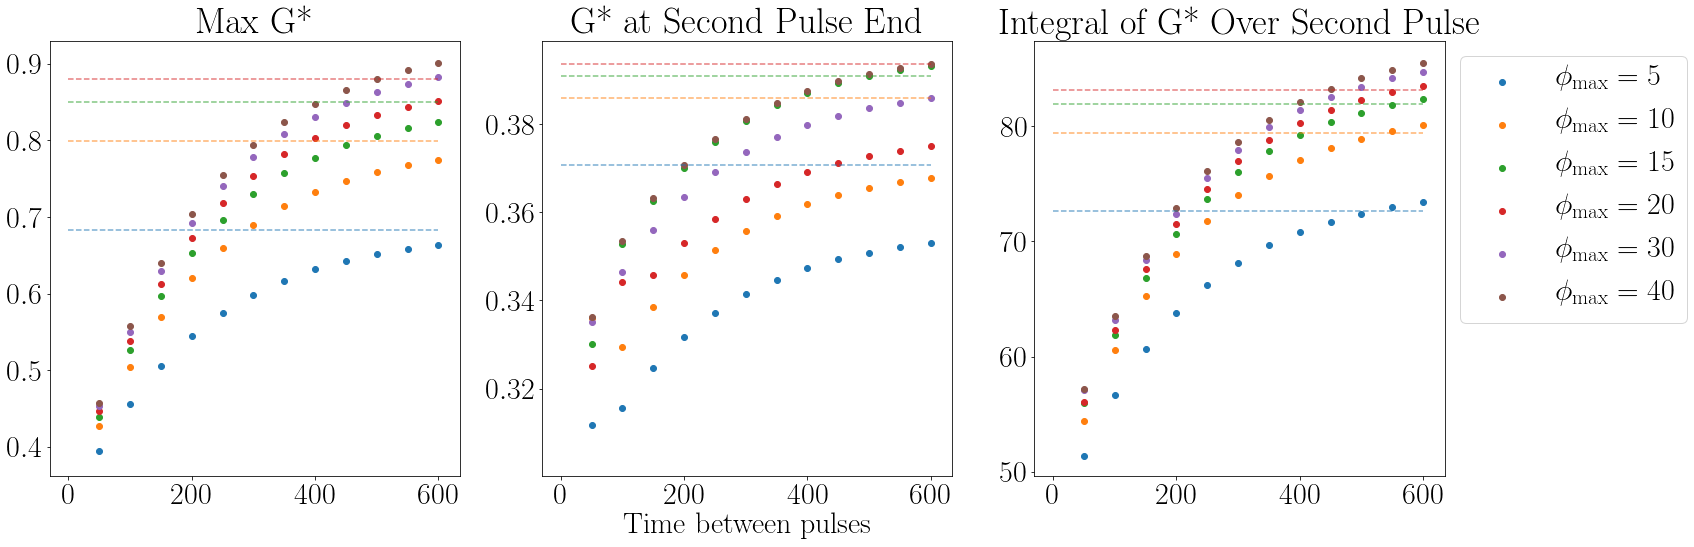

In [45]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 3, figsize=(25,8))

for glut in glut_levels:
    ax[0].scatter(xs, max_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[1].scatter(xs, end_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[2].scatter(xs, second_pulse_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')

    #plot baselines, only the first 4 before it gets messy
    if(glut < 21):
        ax[0].plot([0, max(xs)], [baseline_Gstars[glut][0], baseline_Gstars[glut][0]], linestyle='--', alpha=0.6)
        ax[1].plot([0, max(xs)], [baseline_Gstars[glut][1], baseline_Gstars[glut][1]], linestyle='--', alpha=0.6)
        ax[2].plot([0, max(xs)], [baseline_Gstars[glut][2], baseline_Gstars[glut][2]], linestyle='--', alpha=0.6)

    
ax[0].set_title('Max G*')
ax[1].set_title('G* at Second Pulse End')
ax[2].set_title('Integral of G* Over Second Pulse')

ax[1].set_xlabel('Time between pulses')
ax[2].legend(bbox_to_anchor=(1, 1))


fig.savefig(save + '5.2_glutamate_oscillations_Gstar_characteristics_150s.png', bbox_inches='tight')

### Double bath, varying glutamate strength (Pulse on 30s)

This experiment uses the same protocols as the previous plot, but we will modify how strongly the glutamate strength is set to. Here, we are only plotting the summary characteristics of G*

In [34]:
'''
This section of code is to collect the G* summary characteristics from numerical simulation
'''

num_oscillations = 2
glut_max = 5
oscillation_on_duration = 30
glut_levels = [5, 10, 15, 20, 30, 40]
xs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
max_Gstars = {}
end_Gstars = {}
second_pulse_Gstars = {}
baseline_Gstars = {} #this dictionary will hold the same summary characteristics
                     #but computed for the first square wave pulse rather than second
                     #these will be stored as a list with the order being
                     #[0]: max; [1]: G* at end first pulse; [2]: total G* during first pulse

for glut in glut_levels:
    max_Gstars[glut] = []
    end_Gstars[glut] = []
    second_pulse_Gstars[glut] = []
    baseline_Gstars[glut] = []
    
    
for glut in glut_levels:
    collect_baseline = True
    glut_max = glut
    for x in xs:
        oscillation_off_duration = x

        sol = run_experiment(make_plot=False, input_type='oscillation')
        Gstar = sol.y[0]
        Gd1 = sol.y[1]
        Gd2 = sol.y[2]
        G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
        t = sol.t
        
        #-------
        #Compute baselines
        #-------
        if(collect_baseline):
            collect_baseline = False
            end_first_pulse_index = np.argmax(t > oscillation_on_duration)
            
            max_Gstar = Gstar[:end_first_pulse_index].max()
            end_Gstar = Gstar[end_first_pulse_index]
            mean_Gstar = Gstar[:end_first_pulse_index].mean()
            total_Gstar = mean_Gstar * oscillation_on_duration
            
            baseline_Gstars[glut].append(max_Gstar)
            baseline_Gstars[glut].append(end_Gstar)
            baseline_Gstars[glut].append(total_Gstar)
        
        #-------
        #Compute details
        #-------
        #Starting from second pulse
        start_pulse_index = np.argmax(t > (x + oscillation_on_duration))
        end_pulse_index = np.argmax(t > (x + oscillation_on_duration * 2))

        #1. Max G*
        max_Gstar = Gstar[start_pulse_index:].max()

        #2. G* at end of second pulse
        end_Gstar = Gstar[end_pulse_index]

        #3 Integral of G* over second pulse
        mean_Gstar = Gstar[start_pulse_index:end_pulse_index].mean()
        second_pulse_Gstar = mean_Gstar * oscillation_on_duration

        max_Gstars[glut].append(max_Gstar)
        end_Gstars[glut].append(end_Gstar)
        second_pulse_Gstars[glut].append(second_pulse_Gstar)
        

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


Wall time: 10.6 s


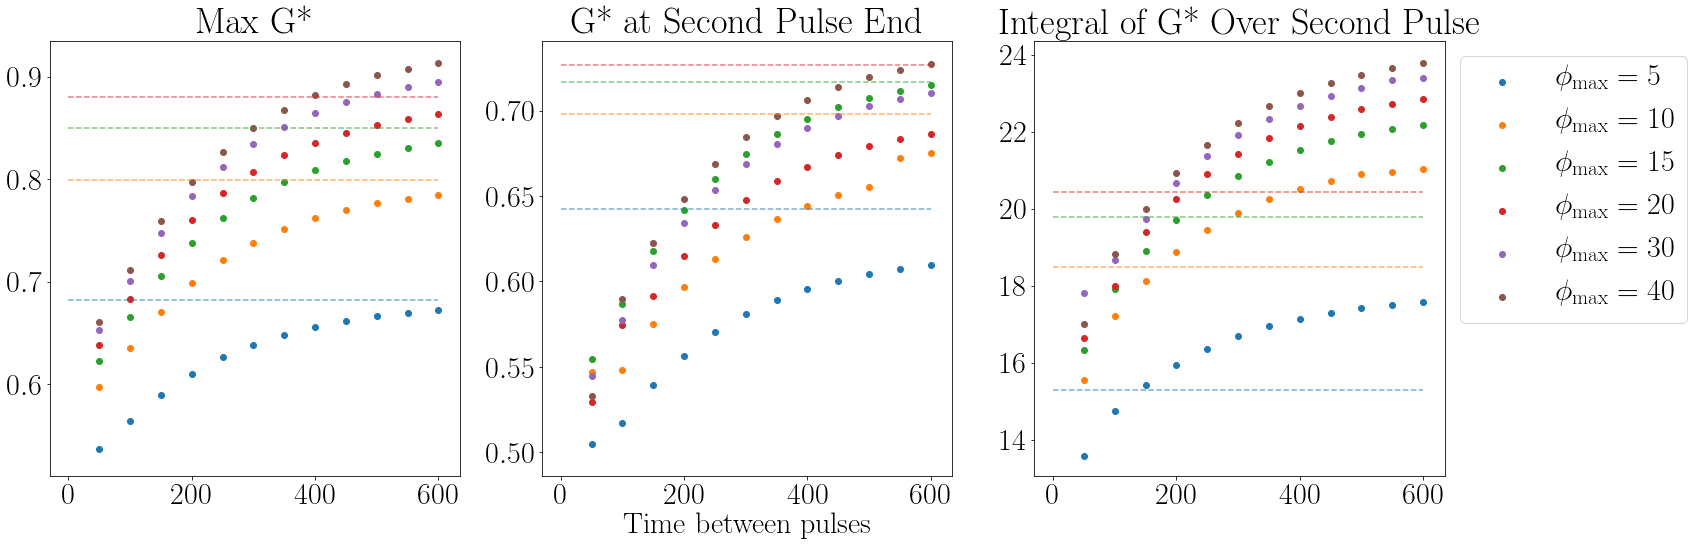

In [43]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 3, figsize=(25,8))

for glut in glut_levels:
    ax[0].scatter(xs, max_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[1].scatter(xs, end_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[2].scatter(xs, second_pulse_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')

    #plot baselines, only the first 4 before it gets messy
    if(glut < 21):
        ax[0].plot([0, max(xs)], [baseline_Gstars[glut][0], baseline_Gstars[glut][0]], linestyle='--', alpha=0.6)
        ax[1].plot([0, max(xs)], [baseline_Gstars[glut][1], baseline_Gstars[glut][1]], linestyle='--', alpha=0.6)
        ax[2].plot([0, max(xs)], [baseline_Gstars[glut][2], baseline_Gstars[glut][2]], linestyle='--', alpha=0.6)

    
ax[0].set_title('Max G*')
ax[1].set_title('G* at Second Pulse End')
ax[2].set_title('Integral of G* Over Second Pulse')

ax[1].set_xlabel('Time between pulses')
ax[2].legend(bbox_to_anchor=(1, 1))


fig.savefig(save + '5.2_glutamate_oscillations_Gstar_characteristics_30s.png', bbox_inches='tight')

### Double bath, varying glutamate strength (Pulse on 50s)

This experiment uses the same protocols as the previous plot, but we will modify how strongly the glutamate strength is set to. Here, we are only plotting the summary characteristics of G*

In [46]:
'''
This section of code is to collect the G* summary characteristics from numerical simulation
'''

num_oscillations = 2
glut_max = 5
oscillation_on_duration = 50
glut_levels = [5, 10, 15, 20, 30, 40]
xs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
max_Gstars = {}
end_Gstars = {}
second_pulse_Gstars = {}
baseline_Gstars = {} #this dictionary will hold the same summary characteristics
                     #but computed for the first square wave pulse rather than second
                     #these will be stored as a list with the order being
                     #[0]: max; [1]: G* at end first pulse; [2]: total G* during first pulse

for glut in glut_levels:
    max_Gstars[glut] = []
    end_Gstars[glut] = []
    second_pulse_Gstars[glut] = []
    baseline_Gstars[glut] = []
    
    
for glut in glut_levels:
    collect_baseline = True
    glut_max = glut
    for x in xs:
        oscillation_off_duration = x

        sol = run_experiment(make_plot=False, input_type='oscillation')
        Gstar = sol.y[0]
        Gd1 = sol.y[1]
        Gd2 = sol.y[2]
        G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
        t = sol.t
        
        #-------
        #Compute baselines
        #-------
        if(collect_baseline):
            collect_baseline = False
            end_first_pulse_index = np.argmax(t > oscillation_on_duration)
            
            max_Gstar = Gstar[:end_first_pulse_index].max()
            end_Gstar = Gstar[end_first_pulse_index]
            mean_Gstar = Gstar[:end_first_pulse_index].mean()
            total_Gstar = mean_Gstar * oscillation_on_duration
            
            baseline_Gstars[glut].append(max_Gstar)
            baseline_Gstars[glut].append(end_Gstar)
            baseline_Gstars[glut].append(total_Gstar)
        
        #-------
        #Compute details
        #-------
        #Starting from second pulse
        start_pulse_index = np.argmax(t > (x + oscillation_on_duration))
        end_pulse_index = np.argmax(t > (x + oscillation_on_duration * 2))

        #1. Max G*
        max_Gstar = Gstar[start_pulse_index:].max()

        #2. G* at end of second pulse
        end_Gstar = Gstar[end_pulse_index]

        #3 Integral of G* over second pulse
        mean_Gstar = Gstar[start_pulse_index:end_pulse_index].mean()
        second_pulse_Gstar = mean_Gstar * oscillation_on_duration

        max_Gstars[glut].append(max_Gstar)
        end_Gstars[glut].append(end_Gstar)
        second_pulse_Gstars[glut].append(second_pulse_Gstar)
        

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


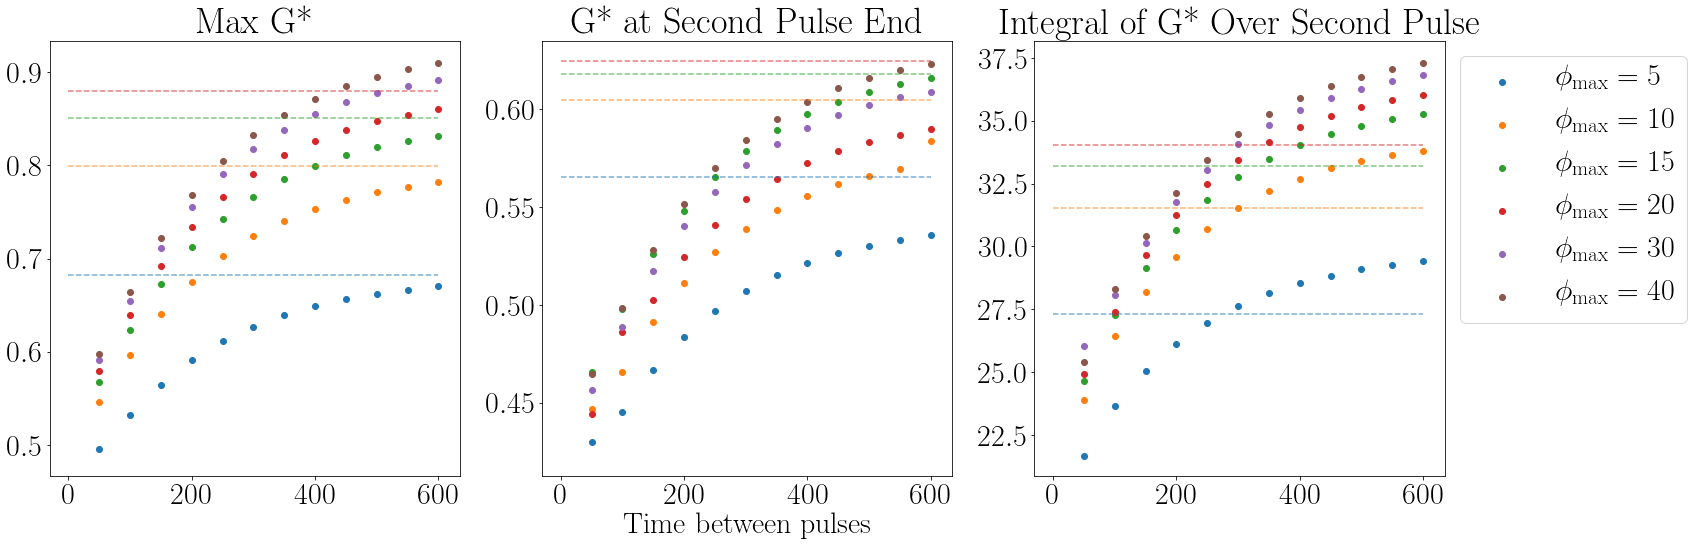

In [47]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 3, figsize=(25,8))

for glut in glut_levels:
    ax[0].scatter(xs, max_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[1].scatter(xs, end_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[2].scatter(xs, second_pulse_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')

    #plot baselines, only the first 4 before it gets messy
    if(glut < 21):
        ax[0].plot([0, max(xs)], [baseline_Gstars[glut][0], baseline_Gstars[glut][0]], linestyle='--', alpha=0.6)
        ax[1].plot([0, max(xs)], [baseline_Gstars[glut][1], baseline_Gstars[glut][1]], linestyle='--', alpha=0.6)
        ax[2].plot([0, max(xs)], [baseline_Gstars[glut][2], baseline_Gstars[glut][2]], linestyle='--', alpha=0.6)

    
ax[0].set_title('Max G*')
ax[1].set_title('G* at Second Pulse End')
ax[2].set_title('Integral of G* Over Second Pulse')

ax[1].set_xlabel('Time between pulses')
ax[2].legend(bbox_to_anchor=(1, 1))


fig.savefig(save + '5.2_glutamate_oscillations_Gstar_characteristics_50s.png', bbox_inches='tight')

### Double bath, varying glutamate strength (Pulse on 100s)

This experiment uses the same protocols as the previous plot, but we will modify how strongly the glutamate strength is set to. Here, we are only plotting the summary characteristics of G*

In [49]:
'''
This section of code is to collect the G* summary characteristics from numerical simulation
'''

num_oscillations = 2
glut_max = 5
oscillation_on_duration = 100
glut_levels = [5, 10, 15, 20, 30, 40]
xs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
max_Gstars = {}
end_Gstars = {}
second_pulse_Gstars = {}
baseline_Gstars = {} #this dictionary will hold the same summary characteristics
                     #but computed for the first square wave pulse rather than second
                     #these will be stored as a list with the order being
                     #[0]: max; [1]: G* at end first pulse; [2]: total G* during first pulse

for glut in glut_levels:
    max_Gstars[glut] = []
    end_Gstars[glut] = []
    second_pulse_Gstars[glut] = []
    baseline_Gstars[glut] = []
    
    
for glut in glut_levels:
    collect_baseline = True
    glut_max = glut
    for x in xs:
        oscillation_off_duration = x

        sol = run_experiment(make_plot=False, input_type='oscillation')
        Gstar = sol.y[0]
        Gd1 = sol.y[1]
        Gd2 = sol.y[2]
        G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
        t = sol.t
        
        #-------
        #Compute baselines
        #-------
        if(collect_baseline):
            collect_baseline = False
            end_first_pulse_index = np.argmax(t > oscillation_on_duration)
            
            max_Gstar = Gstar[:end_first_pulse_index].max()
            end_Gstar = Gstar[end_first_pulse_index]
            mean_Gstar = Gstar[:end_first_pulse_index].mean()
            total_Gstar = mean_Gstar * oscillation_on_duration
            
            baseline_Gstars[glut].append(max_Gstar)
            baseline_Gstars[glut].append(end_Gstar)
            baseline_Gstars[glut].append(total_Gstar)
        
        #-------
        #Compute details
        #-------
        #Starting from second pulse
        start_pulse_index = np.argmax(t > (x + oscillation_on_duration))
        end_pulse_index = np.argmax(t > (x + oscillation_on_duration * 2))

        #1. Max G*
        max_Gstar = Gstar[start_pulse_index:].max()

        #2. G* at end of second pulse
        end_Gstar = Gstar[end_pulse_index]

        #3 Integral of G* over second pulse
        mean_Gstar = Gstar[start_pulse_index:end_pulse_index].mean()
        second_pulse_Gstar = mean_Gstar * oscillation_on_duration

        max_Gstars[glut].append(max_Gstar)
        end_Gstars[glut].append(end_Gstar)
        second_pulse_Gstars[glut].append(second_pulse_Gstar)
        

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


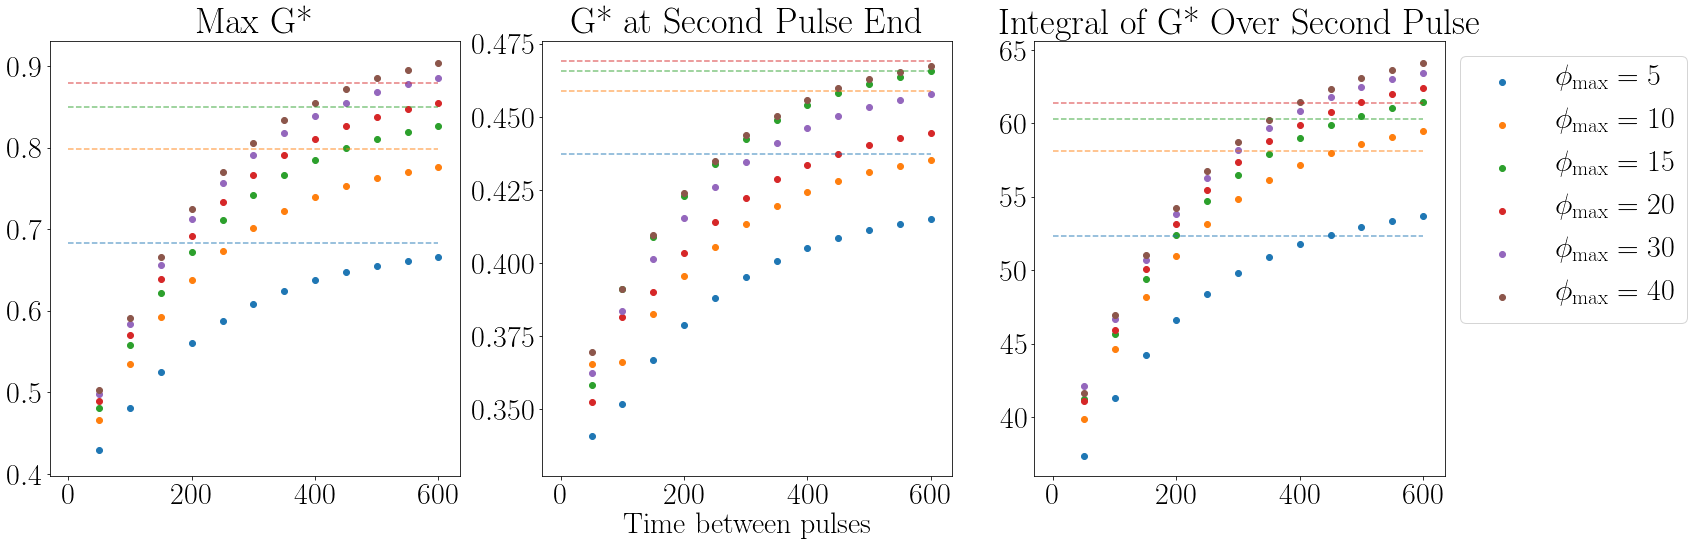

In [50]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 3, figsize=(25,8))

for glut in glut_levels:
    ax[0].scatter(xs, max_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[1].scatter(xs, end_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')
    ax[2].scatter(xs, second_pulse_Gstars[glut], label=r'$\phi_{\max} = ' + str(glut) + '$')

    #plot baselines, only the first 4 before it gets messy
    if(glut < 21):
        ax[0].plot([0, max(xs)], [baseline_Gstars[glut][0], baseline_Gstars[glut][0]], linestyle='--', alpha=0.6)
        ax[1].plot([0, max(xs)], [baseline_Gstars[glut][1], baseline_Gstars[glut][1]], linestyle='--', alpha=0.6)
        ax[2].plot([0, max(xs)], [baseline_Gstars[glut][2], baseline_Gstars[glut][2]], linestyle='--', alpha=0.6)

    
ax[0].set_title('Max G*')
ax[1].set_title('G* at Second Pulse End')
ax[2].set_title('Integral of G* Over Second Pulse')

ax[1].set_xlabel('Time between pulses')
ax[2].legend(bbox_to_anchor=(1, 1))


fig.savefig(save + '5.2_glutamate_oscillations_Gstar_characteristics_100s.png', bbox_inches='tight')

## Repetitive pulses

This experiment involves giving many short small pulses of glutamate. 
10 pulses, 500microM amplitude, 0.06s duration, y=5 seconds between pulses. We need to record with a small max step. Record:
* Max G* from 1st, 2nd, 3rd, last pulse
* Jump in G* from 1st, 2nd, 3rd, last pulse
* Largest value of Gd1 in experiment
* Largest value of Gd2 in experiment

First, we plot what the experiment looks like

Wall time: 691 ms


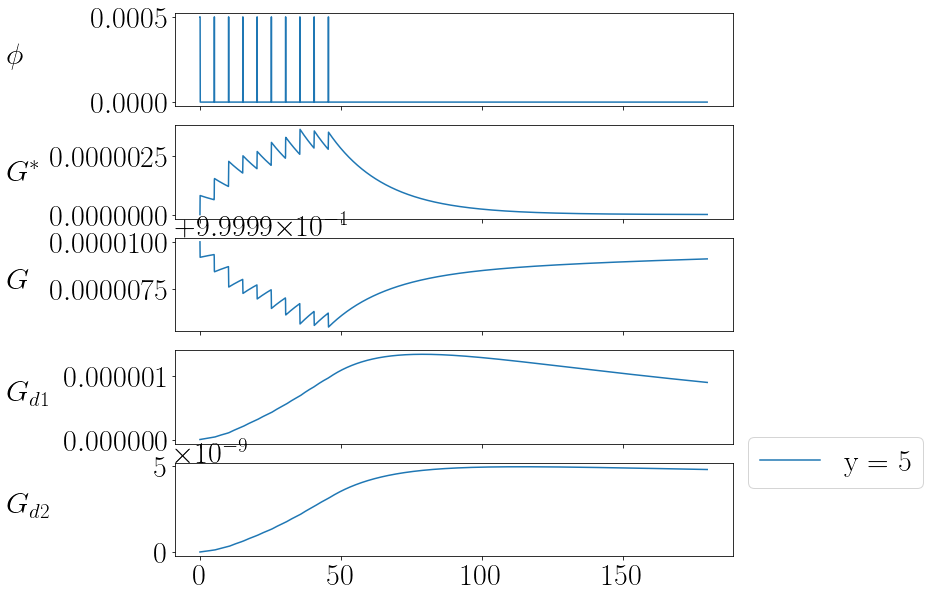

<Figure size 720x720 with 0 Axes>

In [75]:
%%time

'''
Plot what the quick pulses looks like
'''
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))

num_oscillations = 10
glut_max = 500* 10**-6
oscillation_on_duration = 0.06
# ys = [5, 7.5, 10, 12.5, 15]
ys = [5]
final_t = (max(ys)+1) * 10 * 3
    
max_Gstars = []
jump_in_Gstars = []
max_Gd1 = 0
max_Gd2 = 0
    
for y in ys:
    oscillation_off_duration = y
    oscillation_duration = y + 0.06

    sol = run_experiment(make_plot=False, input_type='oscillation', t_f=final_t, max_step=0.05)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t

    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='y = '+ str(y))
    
    glut_t, glut = get_input_plot('oscillation', t_f=final_t)
    ax[0].plot(glut_t, glut)
    
    #-------
    #Compute details
    #-------
    #Starting from second pulse
    first_pulse_index = 0
    second_pulse_index = np.argmax(t > oscillation_duration)
    third_pulse_index = np.argmax(t > 2 * oscillation_duration)
    last_pulse_index = np.argmax(t > 9 * oscillation_duration)
    
    
    #1. Max G* in each pulse
    max_Gstars.append(Gstar[:10].max()) #max after first pulse
    max_Gstars.append(Gstar[second_pulse_index-10 : second_pulse_index+10].max()) #max after second pulse
    max_Gstars.append(Gstar[third_pulse_index-10 : third_pulse_index+10].max()) #max after third pulse
    max_Gstars.append(Gstar[last_pulse_index-10 : last_pulse_index+10].max()) #max after last pulse
    
    #2. Jumps in G* after each pulse
    Gstar_before_pulse = [Gstar[first_pulse_index], Gstar[second_pulse_index-1],
                              Gstar[third_pulse_index-1], Gstar[last_pulse_index-1]] #Get values of Gstar before each pulse
    jump_in_Gstars.append(max_Gstars[0] - Gstar_before_pulse[0])
    jump_in_Gstars.append(max_Gstars[1] - Gstar_before_pulse[1])
    jump_in_Gstars.append(max_Gstars[2] - Gstar_before_pulse[2])
    jump_in_Gstars.append(max_Gstars[3] - Gstar_before_pulse[3])
    
    #3. Largest value of Gd1
    max_Gd1 = Gd1.max()
    
    #4. Largest value of Gd2
    max_Gd2 = Gd2.max()
      
    
ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

ax[4].legend(loc='center left', bbox_to_anchor=(1, 1))

ax[0].get_yaxis().set_label_coords(-0.3, 0.4)
ax[1].get_yaxis().set_label_coords(-0.3, 0.35)
ax[2].get_yaxis().set_label_coords(-0.3, 0.4)
ax[3].get_yaxis().set_label_coords(-0.3, 0.35)
ax[4].get_yaxis().set_label_coords(-0.3, 0.35)

fig.savefig(save + '5.3_quick_pulses.png', bbox_inches='tight')

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


### Multiple pulses for different times between pulses

Now, we conduct the experiment for multiple values of y (time between pulses).

**Observation**: If we look closely at the Jump in G* plot, it seems like an increase in time between pulses doesn't affect how much G* is jumped by a pulse of glutamate. This is suggesting that the G available to activate to G* is basically not affected by previous pulses.

**Problem**: There is some weirdness happening here where the second and third pulses increase the jump in G* more than the first pulse. The only positively contributing term in dG* is due to $k_+ \phi G$, and G is lower at later pulses so this should be a monotonically decreasing function of pulse number. This may be due to some weirdness in the ODE solver step size. 

Wall time: 53.9 s


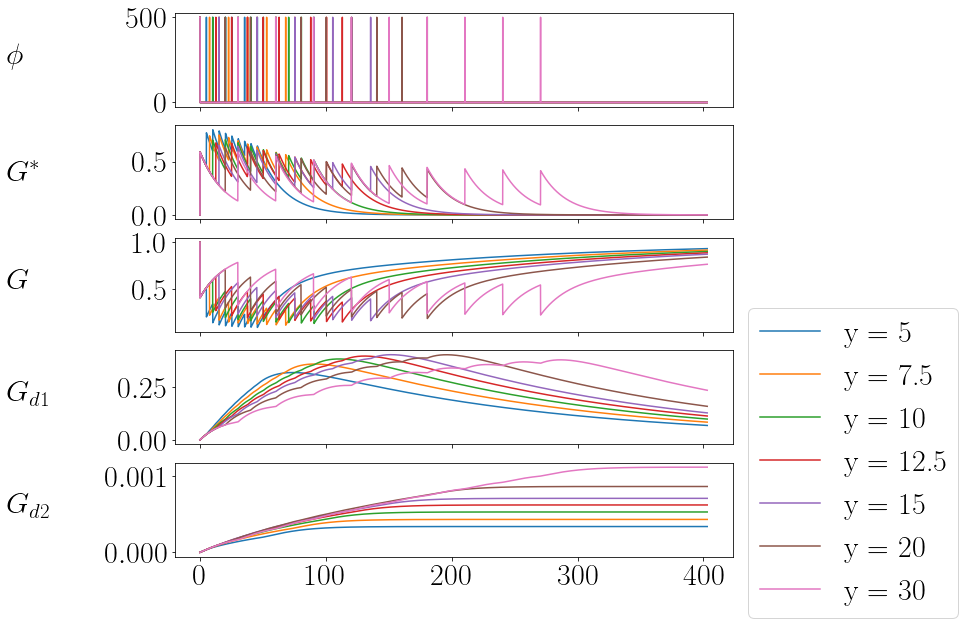

<Figure size 720x720 with 0 Axes>

In [21]:
%%time

'''
Here we are just collecting the data for the experiments
'''
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))

num_oscillations = 10
glut_max = 500
oscillation_on_duration = 0.06
ys = [5, 7.5, 10, 12.5, 15, 20, 30]
# ys = [30]
final_t = (max(ys)+1) * 10 * 1.3
    
max_Gstars = {}
jump_in_Gstars = {}
max_Gd1 = []
max_Gd2 = []

for y in ys:
    max_Gstars[y] = []
    jump_in_Gstars[y] = []
    
for y in ys:
    oscillation_off_duration = y
    oscillation_duration = y + 0.06

    sol = run_experiment(make_plot=False, input_type='oscillation', t_f=final_t, max_step=0.01)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t

    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='y = '+ str(y))
    
    glut_t, glut = get_input_plot('oscillation', t_f=final_t)
    ax[0].plot(glut_t, glut)
    
    #-------
    #Compute details
    #-------
    #Starting from second pulse
    first_pulse_index = 0
    second_pulse_index = np.argmax(t > oscillation_duration)
    third_pulse_index = np.argmax(t > 2 * oscillation_duration)
    last_pulse_index = np.argmax(t > 9 * oscillation_duration)
    
    
    #1. Max G* in each pulse
    max_Gstars[y].append((Gstar[:10].max())) #max after first pulse
    max_Gstars[y].append((Gstar[second_pulse_index-10 : second_pulse_index+10].max())) #max after second pulse
    max_Gstars[y].append((Gstar[third_pulse_index-10 : third_pulse_index+10].max())) #max after third pulse
    max_Gstars[y].append((Gstar[last_pulse_index-10 : last_pulse_index+10].max())) #max after last pulse
    
    #2. Jumps in G* after each pulse
    Gstar_before_pulse = [Gstar[first_pulse_index]*10**6, Gstar[second_pulse_index-1],
                              Gstar[third_pulse_index-1]*10**6, Gstar[last_pulse_index-1]] #Get values of Gstar before each pulse
    jump_in_Gstars[y].append(max_Gstars[y][0] - Gstar_before_pulse[0])
    jump_in_Gstars[y].append(max_Gstars[y][1] - Gstar_before_pulse[1])
    jump_in_Gstars[y].append(max_Gstars[y][2] - Gstar_before_pulse[2])
    jump_in_Gstars[y].append(max_Gstars[y][3] - Gstar_before_pulse[3])
    
    #3. Largest value of Gd1
    max_Gd1.append(Gd1.max())
    
    #4. Largest value of Gd2
    max_Gd2.append(Gd2.max())
      
    
ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

ax[4].legend(loc='center left', bbox_to_anchor=(1, 1))

ax[0].get_yaxis().set_label_coords(-0.3, 0.4)
ax[1].get_yaxis().set_label_coords(-0.3, 0.35)
ax[2].get_yaxis().set_label_coords(-0.3, 0.4)
ax[3].get_yaxis().set_label_coords(-0.3, 0.35)
ax[4].get_yaxis().set_label_coords(-0.3, 0.35)

# fig.savefig(save + '5.3_quick_pulses.png', bbox_inches='tight')

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


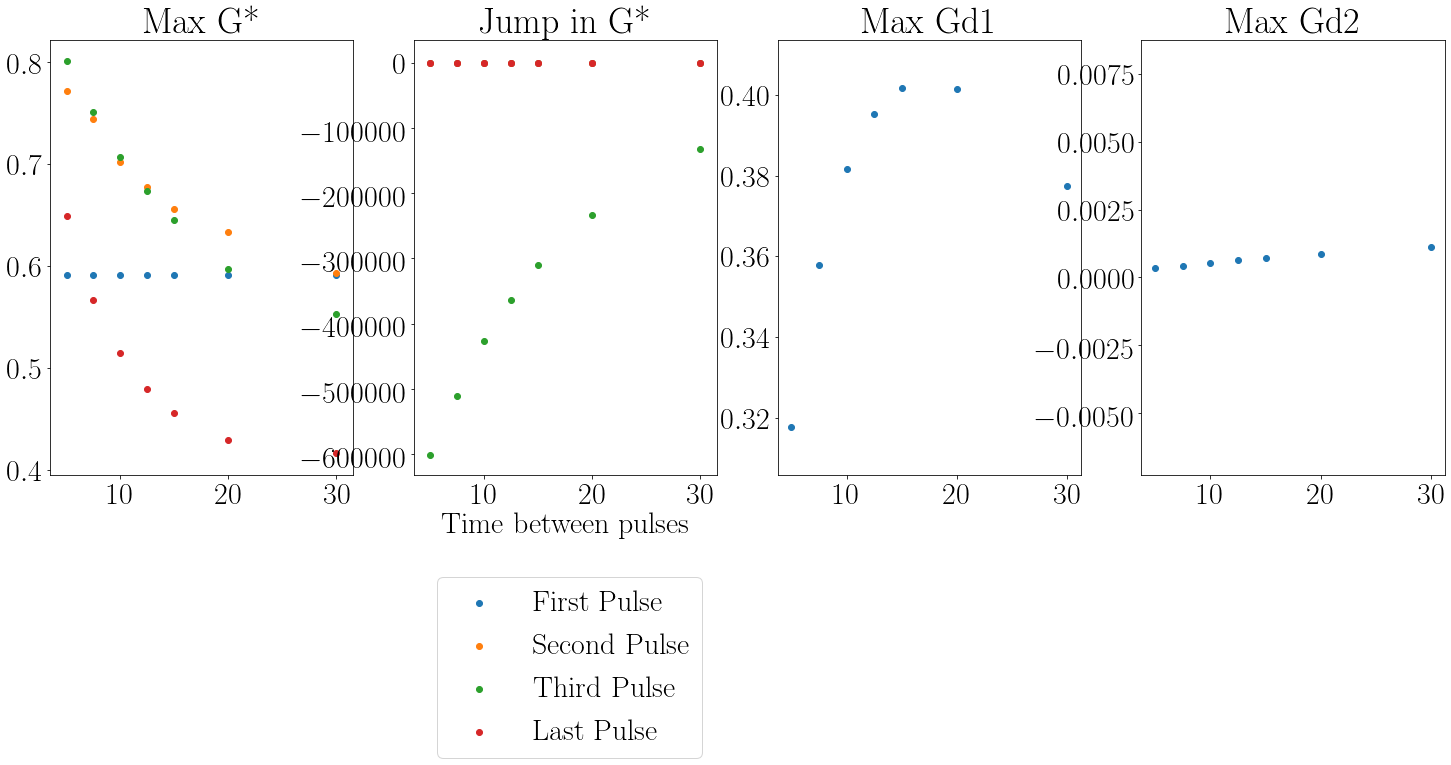

In [24]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 4, figsize=(25,8))

#rearange the data to be organized by which jump
max_pulses = []
jump_in_pulses = []

max_ylim = 0
jump_ylim = 0
Gd1_ylim = max(max_Gd1) * 1.2
Gd2_ylim = max(max_Gd2) * 1.2

for i in range(4):
    #0: first pulse, 1: second pulse, 2: third pulse, 3: last pulse
    max_pulses.append([])
    jump_in_pulses.append([])

for y in ys:
    for i in range(4):
        max_pulses[i].append(max_Gstars[y][i])
        jump_in_pulses[i].append(jump_in_Gstars[y][i])
        
        if(max_Gstars[y][i] > max_ylim):
            max_ylim = max_Gstars[y][i]
        if(jump_in_Gstars[y][i] > jump_ylim):
            jump_ylim = jump_in_Gstars[y][i]
            
max_ylim = max_ylim * 1.2
jump_ylim = jump_ylim * 1.2

labels = ['First Pulse', 'Second Pulse', 'Third Pulse', 'Last Pulse']
for i in range(4):
    ax[0].scatter(ys, max_pulses[i], label=labels[i])
    ax[1].scatter(ys, jump_in_pulses[i], label=labels[i])

    
ax[2].scatter(ys, max_Gd1)
ax[3].scatter(ys, max_Gd2)

    
# ax[0].set_ylim([0, max_ylim])
# ax[1].set_ylim([0, jump_ylim])
# ax[2].set_ylim([0, Gd1_ylim])
# ax[3].set_ylim([0, Gd2_ylim])

ax[0].set_title('Max G*')
ax[1].set_title('Jump in G*')
ax[2].set_title('Max Gd1')
ax[3].set_title('Max Gd2')

ax[1].set_xlabel('Time between pulses')

ax[1].legend(bbox_to_anchor=(1, -0.2))
# ax[2].text(0, -1, r'All values are times ' + r'$10^{-6}$')
# fig.tight_layout()

fig.savefig(save + '5.3_quick_pulses_characteristics.png', bbox_inches='tight')

Evaluating trial 0 of 7
Evaluating trial 1 of 7
Evaluating trial 2 of 7
Evaluating trial 3 of 7
Evaluating trial 4 of 7
Evaluating trial 5 of 7
Evaluating trial 6 of 7
Wall time: 3min 9s


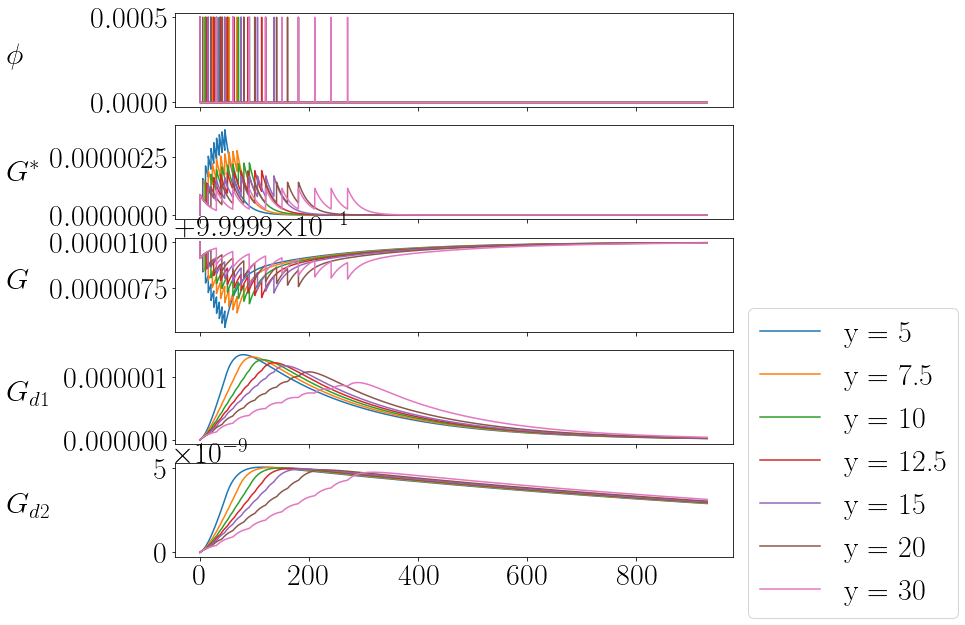

<Figure size 720x720 with 0 Axes>

In [9]:
%%time

'''
Here we are just collecting the data for the experiments
'''
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))

num_oscillations = 10
glut_max = 500* 10**-6
oscillation_on_duration = 0.06
ys = [5, 7.5, 10, 12.5, 15, 20, 30]
# ys = [5]
final_t = (max(ys)+1) * 10 * 3
    
max_Gstars = {}
jump_in_Gstars = {}
max_Gd1 = []
max_Gd2 = []

for y in ys:
    max_Gstars[y] = []
    jump_in_Gstars[y] = []
    
for i, y in enumerate(ys):
    print('Evaluating trial ' + str(i) + ' of ' + str(len(ys)))
    oscillation_off_duration = y
    oscillation_duration = y + 0.06

    sol = run_experiment(make_plot=False, input_type='oscillation', 
                         t_f=final_t, max_step=0.005)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t

    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='y = '+ str(y))
    
    glut_t, glut = get_input_plot('oscillation', t_f=final_t)
    ax[0].plot(glut_t, glut)
    
    #-------
    #Compute details
    #-------
    #Starting from second pulse
    first_pulse_index = 0
    second_pulse_index = np.argmax(t > oscillation_duration)
    third_pulse_index = np.argmax(t > 2 * oscillation_duration)
    last_pulse_index = np.argmax(t > 9 * oscillation_duration)
    
    
    #1. Max G* in each pulse
    max_Gstars[y].append((Gstar[:10].max()) * 10**6) #max after first pulse
    max_Gstars[y].append((Gstar[second_pulse_index-10 : second_pulse_index+10].max()) * 10**6) #max after second pulse
    max_Gstars[y].append((Gstar[third_pulse_index-10 : third_pulse_index+10].max()) * 10**6) #max after third pulse
    max_Gstars[y].append((Gstar[last_pulse_index-10 : last_pulse_index+10].max()) * 10**6) #max after last pulse
    
    #2. Jumps in G* after each pulse
    Gstar_before_pulse = [Gstar[first_pulse_index]*10**6, Gstar[second_pulse_index-1]*10**6,
                              Gstar[third_pulse_index-1]*10**6, Gstar[last_pulse_index-1]*10**6] #Get values of Gstar before each pulse
    jump_in_Gstars[y].append(max_Gstars[y][0] - Gstar_before_pulse[0])
    jump_in_Gstars[y].append(max_Gstars[y][1] - Gstar_before_pulse[1])
    jump_in_Gstars[y].append(max_Gstars[y][2] - Gstar_before_pulse[2])
    jump_in_Gstars[y].append(max_Gstars[y][3] - Gstar_before_pulse[3])
    
    #3. Largest value of Gd1
    max_Gd1.append(Gd1.max() * 10**6)
    
    #4. Largest value of Gd2
    max_Gd2.append(Gd2.max() * 10**6)
      
    
ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

ax[4].legend(loc='center left', bbox_to_anchor=(1, 1))

ax[0].get_yaxis().set_label_coords(-0.3, 0.4)
ax[1].get_yaxis().set_label_coords(-0.3, 0.35)
ax[2].get_yaxis().set_label_coords(-0.3, 0.4)
ax[3].get_yaxis().set_label_coords(-0.3, 0.35)
ax[4].get_yaxis().set_label_coords(-0.3, 0.35)

# fig.savefig(save + '5.3_quick_pulses.png', bbox_inches='tight')

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


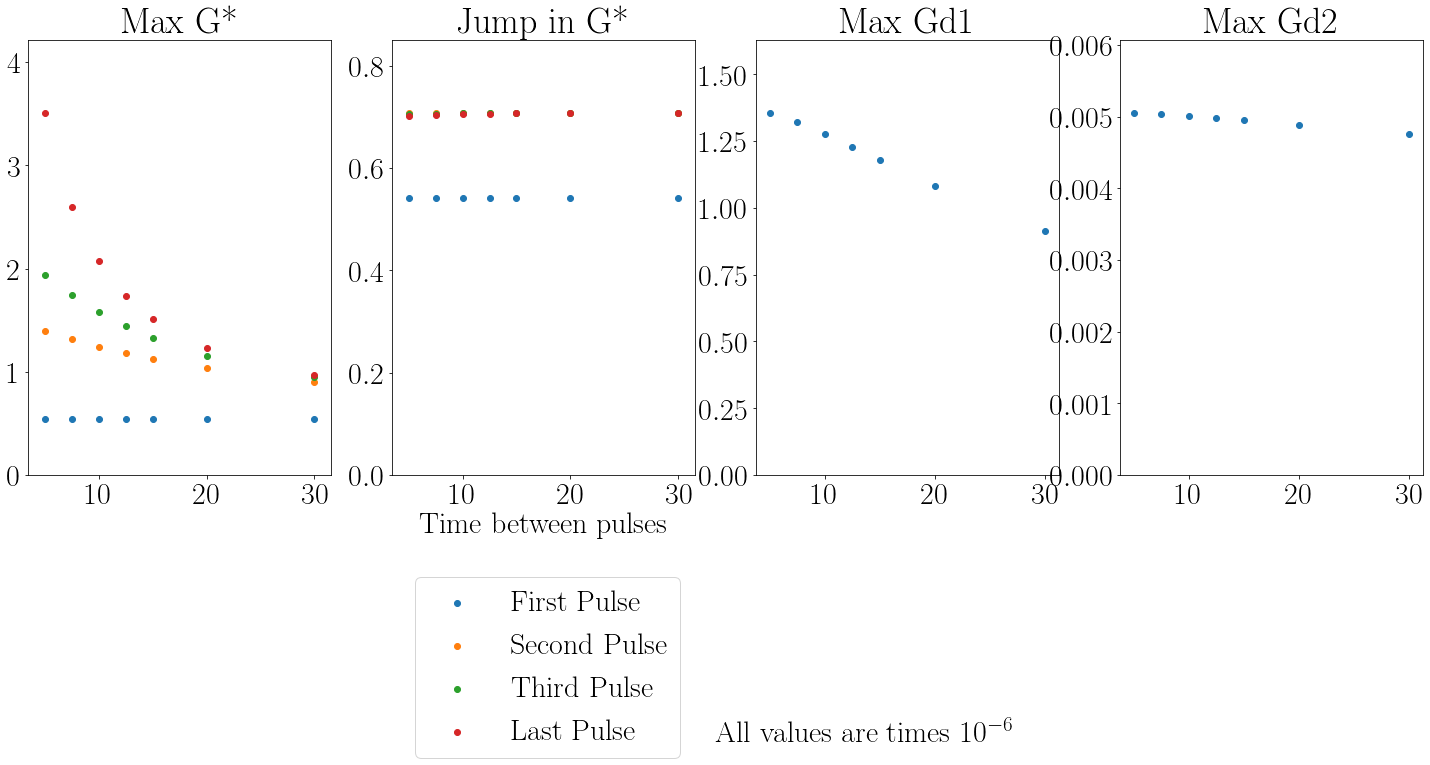

In [115]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 4, figsize=(25,8))

#rearange the data to be organized by which jump
max_pulses = []
jump_in_pulses = []

max_ylim = 0
jump_ylim = 0
Gd1_ylim = max(max_Gd1) * 1.2
Gd2_ylim = max(max_Gd2) * 1.2

for i in range(4):
    #0: first pulse, 1: second pulse, 2: third pulse, 3: last pulse
    max_pulses.append([])
    jump_in_pulses.append([])

for y in ys:
    for i in range(4):
        max_pulses[i].append(max_Gstars[y][i])
        jump_in_pulses[i].append(jump_in_Gstars[y][i])
        
        if(max_Gstars[y][i] > max_ylim):
            max_ylim = max_Gstars[y][i]
        if(jump_in_Gstars[y][i] > jump_ylim):
            jump_ylim = jump_in_Gstars[y][i]
            
max_ylim = max_ylim * 1.2
jump_ylim = jump_ylim * 1.2

labels = ['First Pulse', 'Second Pulse', 'Third Pulse', 'Last Pulse']
for i in range(4):
    ax[0].scatter(ys, max_pulses[i], label=labels[i])
    ax[1].scatter(ys, jump_in_pulses[i], label=labels[i])

    
ax[2].scatter(ys, max_Gd1)
ax[3].scatter(ys, max_Gd2)

    
ax[0].set_ylim([0, max_ylim])
ax[1].set_ylim([0, jump_ylim])
ax[2].set_ylim([0, Gd1_ylim])
ax[3].set_ylim([0, Gd2_ylim])

ax[0].set_title('Max G*')
ax[1].set_title('Jump in G*')
ax[2].set_title('Max Gd1')
ax[3].set_title('Max Gd2')

ax[1].set_xlabel('Time between pulses')

ax[1].legend(bbox_to_anchor=(1, -0.2))
ax[2].text(0, -1, r'All values are times ' + r'$10^{-6}$')
# fig.tight_layout()

fig.savefig(save + '5.3_quick_pulses_characteristics.png', bbox_inches='tight')

## Multiple pulses for different times between pulses (Exponential pulses)

This experiment is the same as the previous but with exponential pulses

Evaluating trial 0 of 1
Wall time: 16.4 s


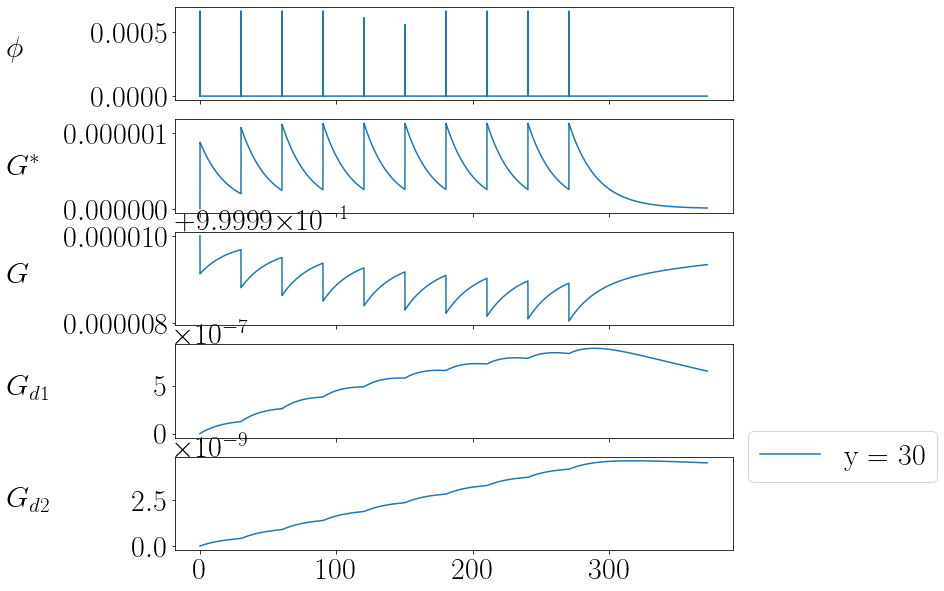

<Figure size 720x720 with 0 Axes>

In [166]:
%%time

'''
Here we are just collecting the data for the experiments
'''
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))
fig = plt.figure(figsize=(10, 10))

num_oscillations = 10
glut_max = 500* 10**-6
oscillation_on_duration = 0.06

#double exponential input with roughly the same total glutamate as previous experiment
d_rise=0.03
d_decay=0.03
A = 0.000666

# ys = [5, 7.5, 10, 12.5, 15, 20, 30]
ys = [30]
final_t = (max(ys)+1) * 10 * 1.2
    
max_Gstars = {}
jump_in_Gstars = {}
max_Gd1 = []
max_Gd2 = []

for y in ys:
    max_Gstars[y] = []
    jump_in_Gstars[y] = []
    
for i, y in enumerate(ys):
    print('Evaluating trial ' + str(i) + ' of ' + str(len(ys)))
    oscillation_off_duration = y
    oscillation_duration = y + 0.06

    sol = run_experiment(make_plot=False, input_type='exponential_oscillation', 
                         t_f=final_t, max_step=0.005)
    Gstar = sol.y[0]
    Gd1 = sol.y[1]
    Gd2 = sol.y[2]
    G = np.full(len(Gstar), 1) - Gstar - Gd1 - Gd2
    t = sol.t

    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2, label='y = '+ str(y))
    
    glut_t, glut = get_input_plot('exponential_oscillation', t_f=final_t)
    ax[0].plot(glut_t, glut)
    
    #-------
    #Compute details
    #-------
    #Starting from second pulse
    first_pulse_index = 0
    second_pulse_index = np.argmax(t > oscillation_duration)
    third_pulse_index = np.argmax(t > 2 * oscillation_duration)
    last_pulse_index = np.argmax(t > 9 * oscillation_duration)
    
    
    #1. Max G* in each pulse
    max_Gstars[y].append((Gstar[:10].max()) * 10**6) #max after first pulse
    max_Gstars[y].append((Gstar[second_pulse_index-10 : second_pulse_index+10].max()) * 10**6) #max after second pulse
    max_Gstars[y].append((Gstar[third_pulse_index-10 : third_pulse_index+10].max()) * 10**6) #max after third pulse
    max_Gstars[y].append((Gstar[last_pulse_index-10 : last_pulse_index+10].max()) * 10**6) #max after last pulse
    
    #2. Jumps in G* after each pulse
    Gstar_before_pulse = [Gstar[first_pulse_index]*10**6, Gstar[second_pulse_index-1]*10**6,
                              Gstar[third_pulse_index-1]*10**6, Gstar[last_pulse_index-1]*10**6] #Get values of Gstar before each pulse
    jump_in_Gstars[y].append(max_Gstars[y][0] - Gstar_before_pulse[0])
    jump_in_Gstars[y].append(max_Gstars[y][1] - Gstar_before_pulse[1])
    jump_in_Gstars[y].append(max_Gstars[y][2] - Gstar_before_pulse[2])
    jump_in_Gstars[y].append(max_Gstars[y][3] - Gstar_before_pulse[3])
    
    #3. Largest value of Gd1
    max_Gd1.append(Gd1.max() * 10**6)
    
    #4. Largest value of Gd2
    max_Gd2.append(Gd2.max() * 10**6)
      
    
ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

ax[4].legend(loc='center left', bbox_to_anchor=(1, 1))

ax[0].get_yaxis().set_label_coords(-0.3, 0.4)
ax[1].get_yaxis().set_label_coords(-0.3, 0.35)
ax[2].get_yaxis().set_label_coords(-0.3, 0.4)
ax[3].get_yaxis().set_label_coords(-0.3, 0.35)
ax[4].get_yaxis().set_label_coords(-0.3, 0.35)

# fig.savefig(save + '5.4_quick_exponential_pulses.png', bbox_inches='tight')

glut_max = 10
oscillation_off_duration = 150
oscillation_on_duration = 50
num_oscillations = 5


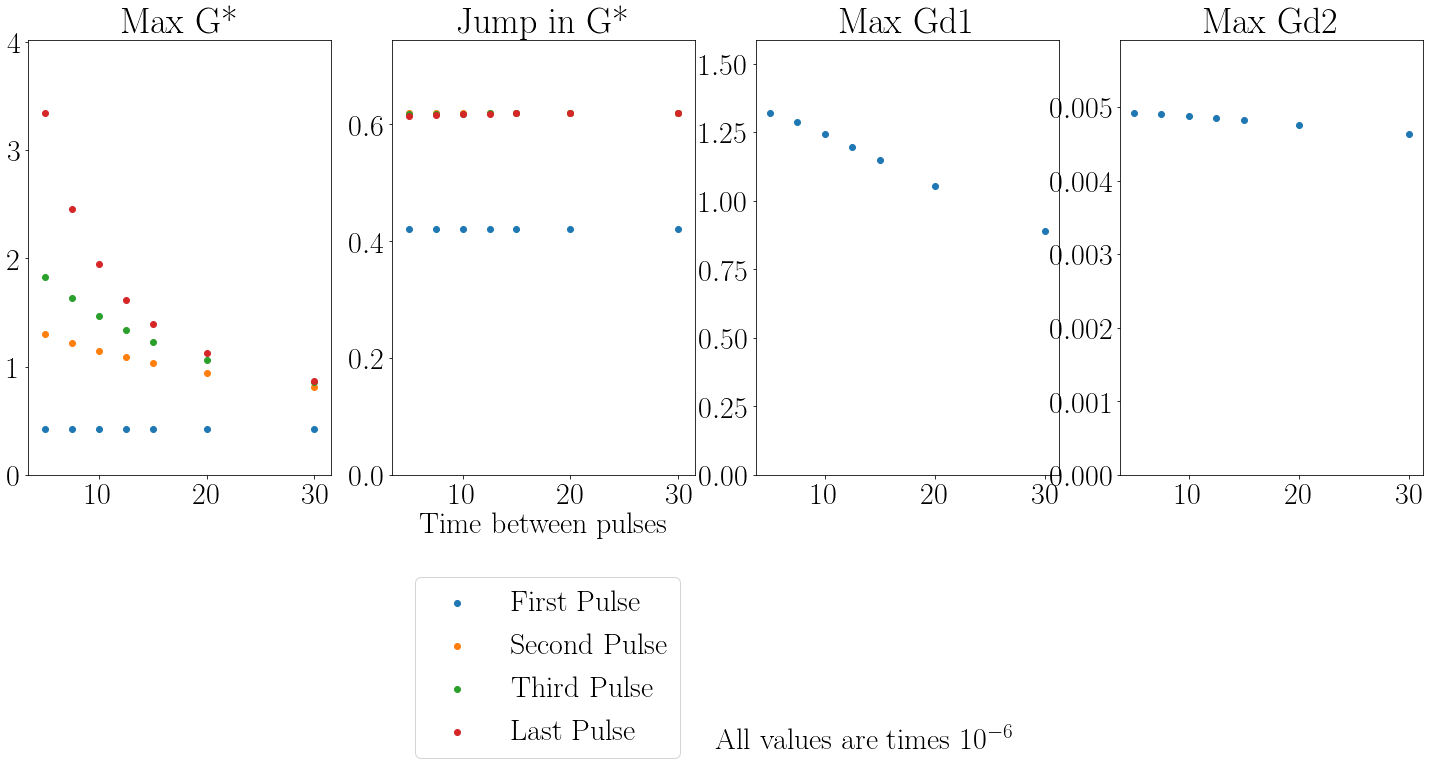

In [162]:
#Plot the second pulse characteristics

fig, ax = plt.subplots(1, 4, figsize=(25,8))

#rearange the data to be organized by which jump
max_pulses = []
jump_in_pulses = []

max_ylim = 0
jump_ylim = 0
Gd1_ylim = max(max_Gd1) * 1.2
Gd2_ylim = max(max_Gd2) * 1.2

for i in range(4):
    #0: first pulse, 1: second pulse, 2: third pulse, 3: last pulse
    max_pulses.append([])
    jump_in_pulses.append([])

for y in ys:
    for i in range(4):
        max_pulses[i].append(max_Gstars[y][i])
        jump_in_pulses[i].append(jump_in_Gstars[y][i])
        
        if(max_Gstars[y][i] > max_ylim):
            max_ylim = max_Gstars[y][i]
        if(jump_in_Gstars[y][i] > jump_ylim):
            jump_ylim = jump_in_Gstars[y][i]
            
max_ylim = max_ylim * 1.2
jump_ylim = jump_ylim * 1.2

labels = ['First Pulse', 'Second Pulse', 'Third Pulse', 'Last Pulse']
for i in range(4):
    ax[0].scatter(ys, max_pulses[i], label=labels[i])
    ax[1].scatter(ys, jump_in_pulses[i], label=labels[i])

    
ax[2].scatter(ys, max_Gd1)
ax[3].scatter(ys, max_Gd2)

    
ax[0].set_ylim([0, max_ylim])
ax[1].set_ylim([0, jump_ylim])
ax[2].set_ylim([0, Gd1_ylim])
ax[3].set_ylim([0, Gd2_ylim])

ax[0].set_title('Max G*')
ax[1].set_title('Jump in G*')
ax[2].set_title('Max Gd1')
ax[3].set_title('Max Gd2')

ax[1].set_xlabel('Time between pulses')

ax[1].legend(bbox_to_anchor=(1, -0.2))
ax[2].text(0, -1, r'All values are times ' + r'$10^{-6}$')
# fig.tight_layout()

fig.savefig(save + '5.4_quick_exponential_pulses_characteristics.png', bbox_inches='tight')

---

# Long bath equilibria

Looking here to test if we can get a range of G* values for long bath applications of glutamate

## Long bath equilibria, default parameters

Here we can see quite clearly that increases in glutamate beyond about $\phi \geq 2$ don't really cause increases in the G* level at equilibrium. This looks like it is primarily driven by conversion of G* to Gd1 as we expected. 

I think increases to kd1 and decreases to kr1 should have the same effect to final equilibrium levels, but kd1 will affect the initial transient behavior of G* and kr1 will effect the length of time to resensitize.

<Figure size 720x1440 with 0 Axes>

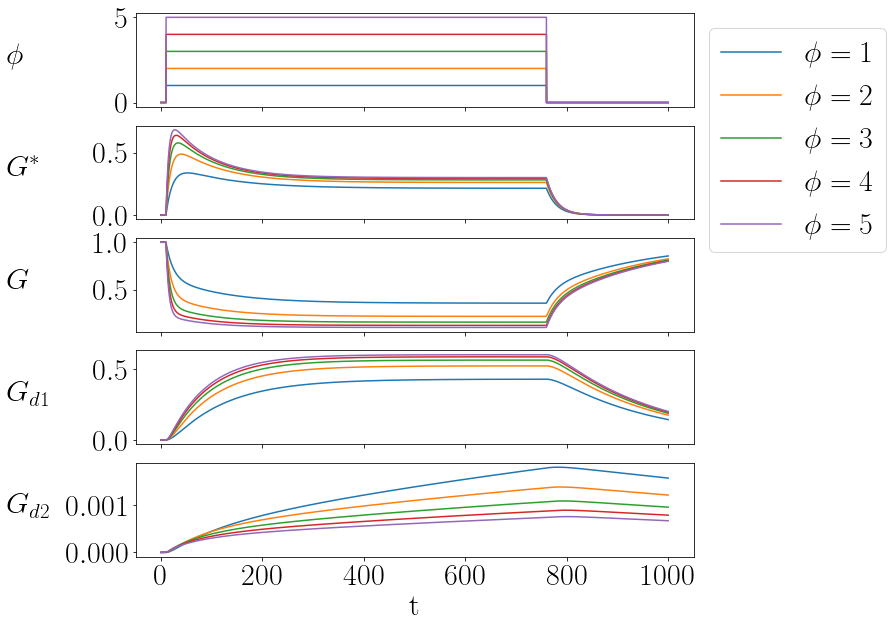

In [45]:
glut_maxes = [1, 2, 3, 4, 5]
glut_max = 1

plt.figure(figsize=(10,20))

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10,10))

for glut in glut_maxes:
    glut_max = glut
    sol = run_experiment(make_plot=False)
    
    #set glutamate plot curve
    glut_t, glut = get_input_plot(sol['glutamate_input_type'])

    #plot figures
    ax[0].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2)

#set xlabel
ax[4].set_xlabel('t')

#set ylabels
ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0].get_yaxis().set_label_coords(-0.23,0.4)
ax[1].get_yaxis().set_label_coords(-0.23,0.4)
ax[2].get_yaxis().set_label_coords(-0.23,0.4)
ax[3].get_yaxis().set_label_coords(-0.23,0.35)
ax[4].get_yaxis().set_label_coords(-0.23,0.35)

ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))

fig.savefig(save + '6.1_long_equilibria_bath_1_5.png', bbox_inches='tight')

<Figure size 720x1440 with 0 Axes>

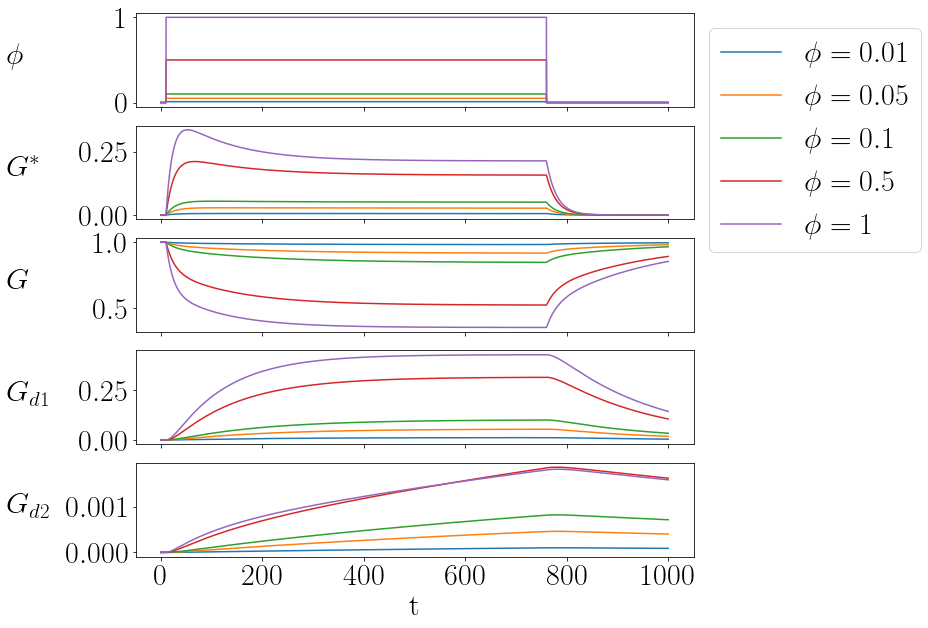

In [46]:
glut_maxes = [0.01, 0.05, 0.1, 0.5, 1]
glut_max = 1

plt.figure(figsize=(10,20))

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10,10))

for glut in glut_maxes:
    glut_max = glut
    sol = run_experiment(make_plot=False)
    
    #set glutamate plot curve
    glut_t, glut = get_input_plot(sol['glutamate_input_type'])

    #plot figures
    ax[0].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1].plot(t, Gstar)
    ax[2].plot(t, G)
    ax[3].plot(t, Gd1)
    ax[4].plot(t, Gd2)

#set xlabel
ax[4].set_xlabel('t')

#set ylabels
ax[0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0].get_yaxis().set_label_coords(-0.23,0.4)
ax[1].get_yaxis().set_label_coords(-0.23,0.4)
ax[2].get_yaxis().set_label_coords(-0.23,0.4)
ax[3].get_yaxis().set_label_coords(-0.23,0.35)
ax[4].get_yaxis().set_label_coords(-0.23,0.35)

ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))

fig.savefig(save + '6.1_long_equilibria_bath_0.1_1.png', bbox_inches='tight')

## Long bath equilibria, change kd1, kr1

### Factor 2 change

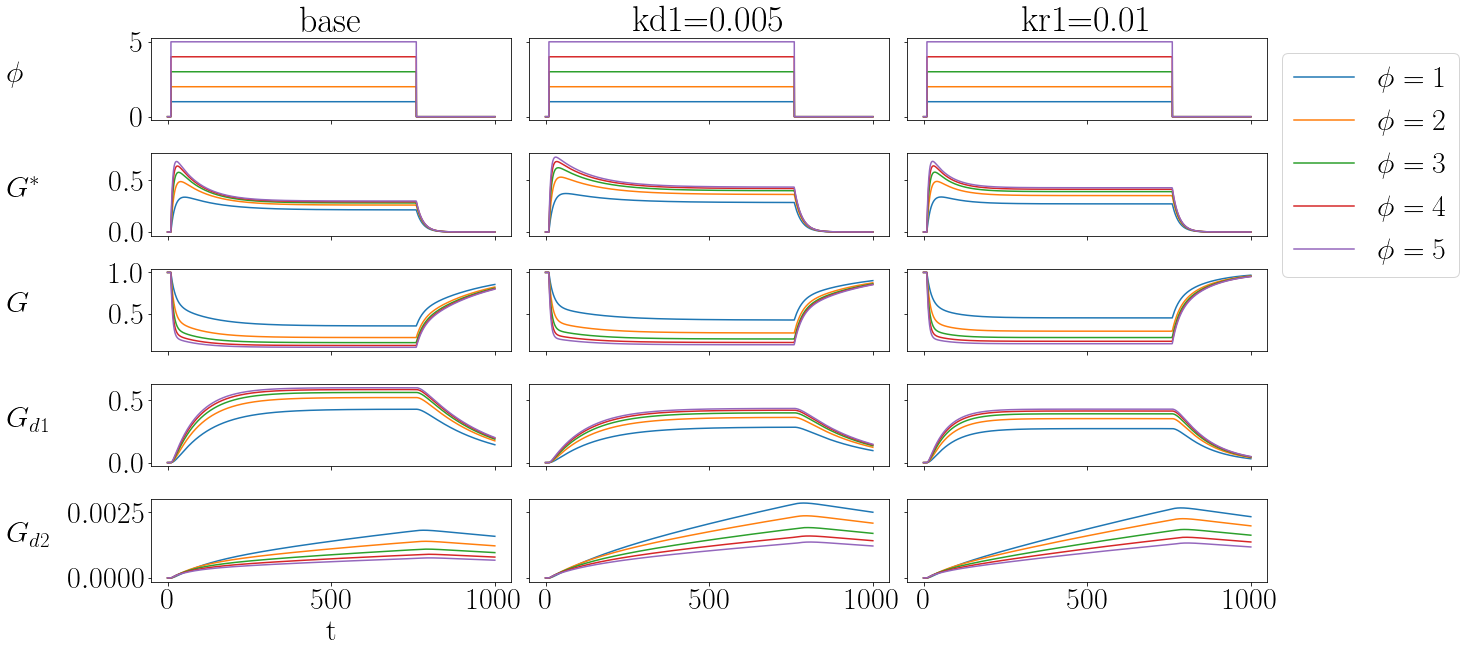

In [47]:
glut_maxes = [1, 2, 3, 4, 5]
glut_max = 1

fig, ax = plt.subplots(5, 3, sharex=True, sharey='row', figsize=(20,10))

for glut in glut_maxes:
    glut_max = glut
    
    sol = run_experiment(make_plot=False)
    
    #set glutamate plot curve
    glut_t, glut = get_input_plot(sol['glutamate_input_type'])

    #plot figures
    ax[0, 0].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 0].plot(t, Gstar)
    ax[2, 0].plot(t, G)
    ax[3, 0].plot(t, Gd1)
    ax[4, 0].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kd1': 0.005})

    #plot figures
    ax[0, 1].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 1].plot(t, Gstar)
    ax[2, 1].plot(t, G)
    ax[3, 1].plot(t, Gd1)
    ax[4, 1].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kr1': 0.01})

    #plot figures
    ax[0, 2].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 2].plot(t, Gstar)
    ax[2, 2].plot(t, G)
    ax[3, 2].plot(t, Gd1)
    ax[4, 2].plot(t, Gd2)
    
ax[0, 0].set_title('base')
ax[0, 1].set_title('kd1=0.005')
ax[0, 2].set_title('kr1=0.01')

#set xlabel
ax[4, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.35)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.35)

ax[0, 2].legend(loc='upper left', bbox_to_anchor=(1,1))
fig.subplots_adjust(wspace=0.05, hspace=0.4)

fig.savefig(save + '6.2.1_long_equilibria_bath_1_5_factor_2_change.png', bbox_inches='tight')

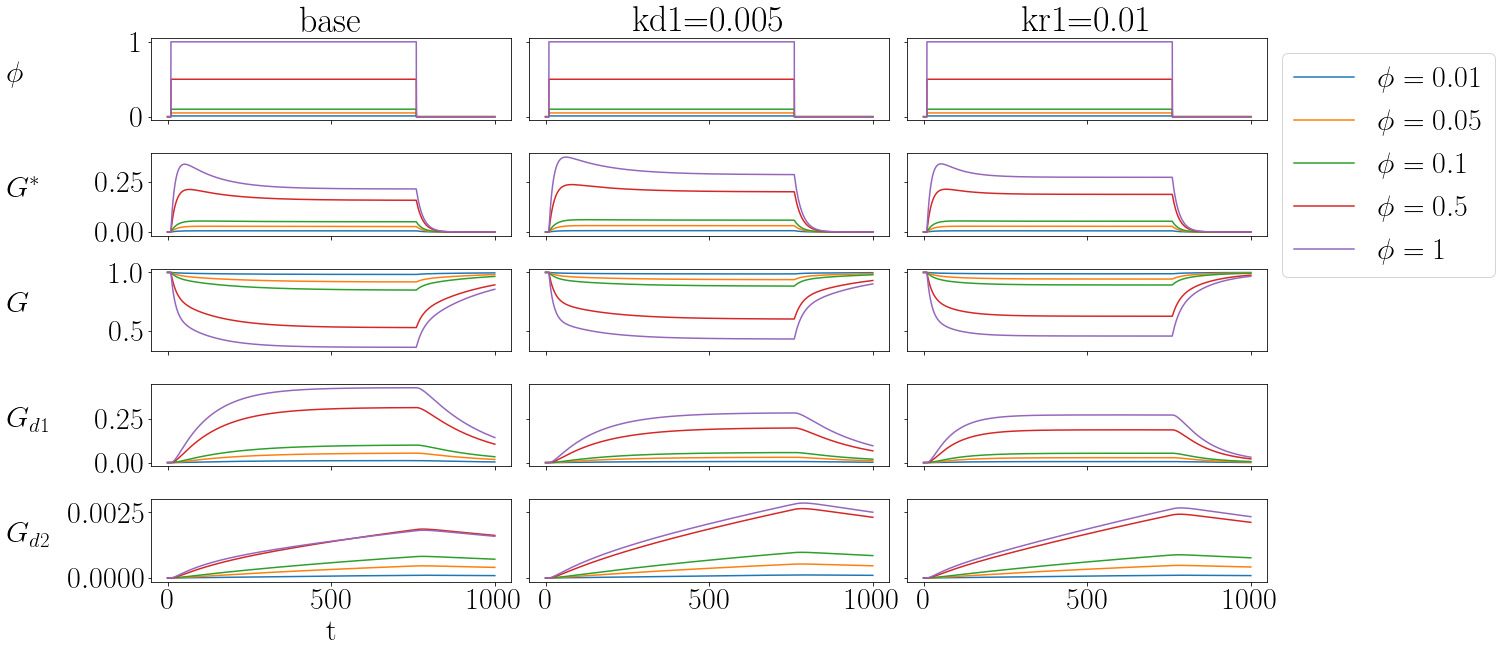

In [42]:
glut_maxes = [0.01, 0.05, 0.1, 0.5, 1]
glut_max = 1

fig, ax = plt.subplots(5, 3, sharex=True, sharey='row', figsize=(20,10))

for glut in glut_maxes:
    glut_max = glut
    
    sol = run_experiment(make_plot=False)
    
    #set glutamate plot curve
    glut_t, glut = get_input_plot(sol['glutamate_input_type'])

    #plot figures
    ax[0, 0].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 0].plot(t, Gstar)
    ax[2, 0].plot(t, G)
    ax[3, 0].plot(t, Gd1)
    ax[4, 0].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kd1': 0.005})

    #plot figures
    ax[0, 1].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 1].plot(t, Gstar)
    ax[2, 1].plot(t, G)
    ax[3, 1].plot(t, Gd1)
    ax[4, 1].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kr1': 0.01})

    #plot figures
    ax[0, 2].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 2].plot(t, Gstar)
    ax[2, 2].plot(t, G)
    ax[3, 2].plot(t, Gd1)
    ax[4, 2].plot(t, Gd2)
    
ax[0, 0].set_title('base')
ax[0, 1].set_title('kd1=0.005')
ax[0, 2].set_title('kr1=0.01')

#set xlabel
ax[4, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.35)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.35)

ax[0, 2].legend(loc='upper left', bbox_to_anchor=(1,1))
fig.subplots_adjust(wspace=0.05, hspace=0.4)

### Factor 10 change

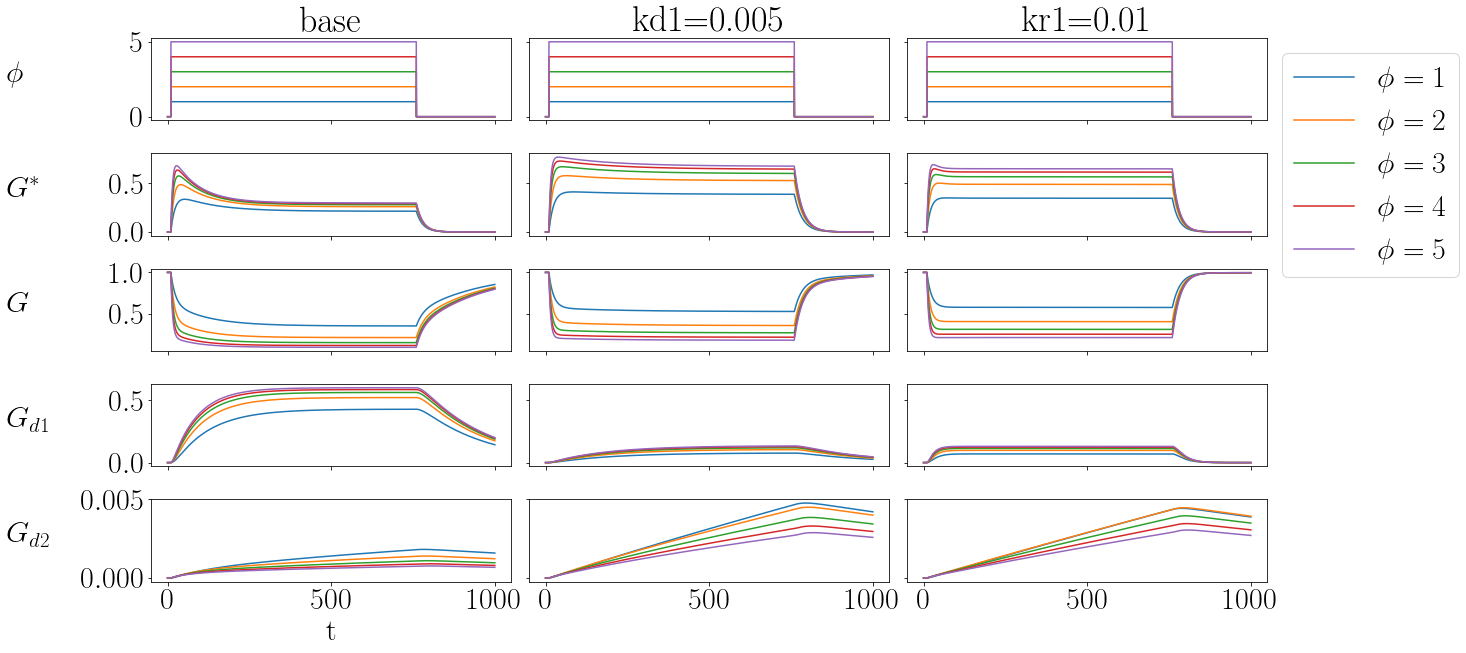

In [48]:
glut_maxes = [1, 2, 3, 4, 5]
glut_max = 1

fig, ax = plt.subplots(5, 3, sharex=True, sharey='row', figsize=(20,10))

for glut in glut_maxes:
    glut_max = glut
    
    sol = run_experiment(make_plot=False)
    
    #set glutamate plot curve
    glut_t, glut = get_input_plot(sol['glutamate_input_type'])

    #plot figures
    ax[0, 0].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 0].plot(t, Gstar)
    ax[2, 0].plot(t, G)
    ax[3, 0].plot(t, Gd1)
    ax[4, 0].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kd1': 0.001})

    #plot figures
    ax[0, 1].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 1].plot(t, Gstar)
    ax[2, 1].plot(t, G)
    ax[3, 1].plot(t, Gd1)
    ax[4, 1].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kr1': 0.05})

    #plot figures
    ax[0, 2].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 2].plot(t, Gstar)
    ax[2, 2].plot(t, G)
    ax[3, 2].plot(t, Gd1)
    ax[4, 2].plot(t, Gd2)
    
ax[0, 0].set_title('base')
ax[0, 1].set_title('kd1=0.005')
ax[0, 2].set_title('kr1=0.01')

#set xlabel
ax[4, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.35)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.35)

ax[0, 2].legend(loc='upper left', bbox_to_anchor=(1,1))
fig.subplots_adjust(wspace=0.05, hspace=0.4)

fig.savefig(save + '6.2.1_long_equilibria_bath_0.1_1_factor_2_change.png', bbox_inches='tight')

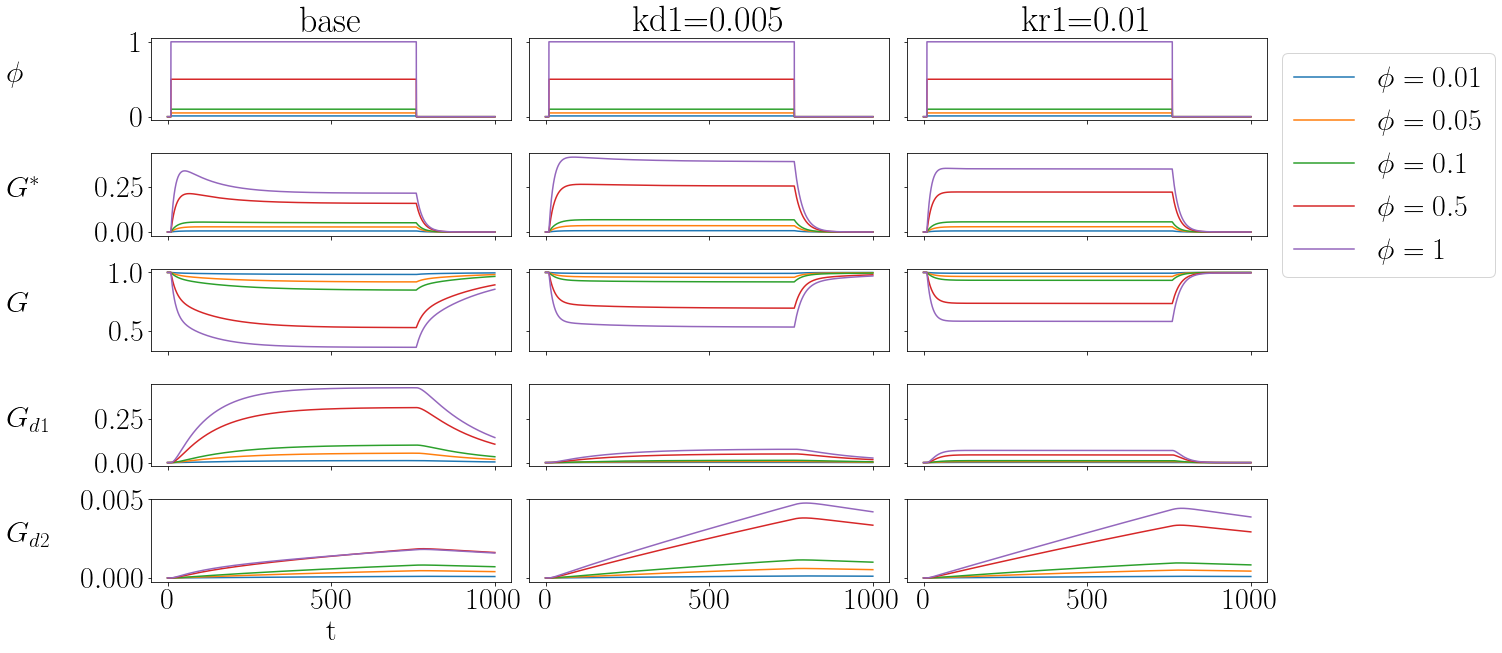

In [39]:
glut_maxes = [0.01, 0.05, 0.1, 0.5, 1]
glut_max = 1

fig, ax = plt.subplots(5, 3, sharex=True, sharey='row', figsize=(20,10))

for glut in glut_maxes:
    glut_max = glut
    
    sol = run_experiment(make_plot=False)
    
    #set glutamate plot curve
    glut_t, glut = get_input_plot(sol['glutamate_input_type'])

    #plot figures
    ax[0, 0].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 0].plot(t, Gstar)
    ax[2, 0].plot(t, G)
    ax[3, 0].plot(t, Gd1)
    ax[4, 0].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kd1': 0.001})

    #plot figures
    ax[0, 1].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 1].plot(t, Gstar)
    ax[2, 1].plot(t, G)
    ax[3, 1].plot(t, Gd1)
    ax[4, 1].plot(t, Gd2)
    
    
    sol = run_experiment(make_plot=False, change_param_dict={'kr1': 0.05})

    #plot figures
    ax[0, 2].plot(glut_t, glut, label=r'$\phi = ' + str(glut_max) + '$')
    ax[1, 2].plot(t, Gstar)
    ax[2, 2].plot(t, G)
    ax[3, 2].plot(t, Gd1)
    ax[4, 2].plot(t, Gd2)
    
ax[0, 0].set_title('base')
ax[0, 1].set_title('kd1=0.005')
ax[0, 2].set_title('kr1=0.01')

#set xlabel
ax[4, 0].set_xlabel('t')

#set ylabels
ax[0, 0].set_ylabel(r'$\phi$', rotation='horizontal', ha='left')
ax[1, 0].set_ylabel(r'$G^*$', rotation='horizontal', ha='left')
ax[2, 0].set_ylabel(r'$G$', rotation='horizontal', ha='left')
ax[3, 0].set_ylabel(r'$G_{d1}$', rotation='horizontal', ha='left')
ax[4, 0].set_ylabel(r'$G_{d2}$', rotation='horizontal', ha='left')

#align ylabels
ax[0, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[1, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[2, 0].get_yaxis().set_label_coords(-0.4,0.4)
ax[3, 0].get_yaxis().set_label_coords(-0.4,0.35)
ax[4, 0].get_yaxis().set_label_coords(-0.4,0.35)

ax[0, 2].legend(loc='upper left', bbox_to_anchor=(1,1))
fig.subplots_adjust(wspace=0.05, hspace=0.4)